In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('No GPU found')
else:
  print(gpu_info)

Mon Jun  3 09:47:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   53C    P0             29W /  140W |    1053MiB /   6144MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
pip list

Package                   Version
------------------------- ------------
absl-py                   2.1.0
anyio                     4.2.0
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 2.0.5
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.11.0
beautifulsoup4            4.12.2
bleach                    4.1.0
Brotli                    1.0.9
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        2.0.4
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.6.7
decorator                 5.1.1
defusedxml                0.7.1
executing                 0.8.3
fastjsonschema            2.16.2
filelock                  3.13.1
fonttools                 4.52.1
fsspec                    2024.2.0
grpcio                    1.64.0
h5py                      3.11.0
idna         

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.models as models
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
from scipy.linalg import sqrtm
from torchsummary import summary
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from h5py import File as HDF5File
%matplotlib inline
import torch.nn as nn
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the Dataset

In [ ]:
jet_images_path = 'GSoC-2024\\Datasets\\jet-mass\\jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'

In [ ]:
jet_images_path = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'

In [ ]:
jet_mass_data = HDF5File(jet_images_path, 'r')

In [ ]:
print(jet_mass_data.keys())

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>


In [ ]:
X_jet = jet_mass_data['image']
print(X_jet.shape)

(872666, 25, 25)


In [ ]:
X_jet = np.array(X_jet)
X_jet = torch.tensor(X_jet, dtype=torch.float32)

# Normalize the data
X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())

X_jet = X_jet.unsqueeze(1)
X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)

print(X_jet_resized.shape)

torch.Size([872666, 1, 16, 16])


In [ ]:
batch_size = 128
dataset = TensorDataset(X_jet_resized)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Visualization


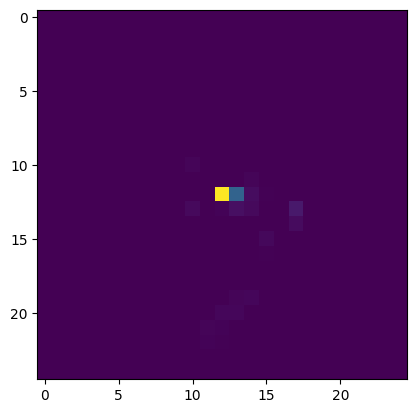

In [ ]:
#Original 25x25 image
plt.imshow(X_jet[2024,:,:])

In [ ]:
def plot_images(images, n_row, n_col):
    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 2, n_row * 2))
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow(images[i * n_col + j])
            axes[i, j].axis('off')
    plt.show()


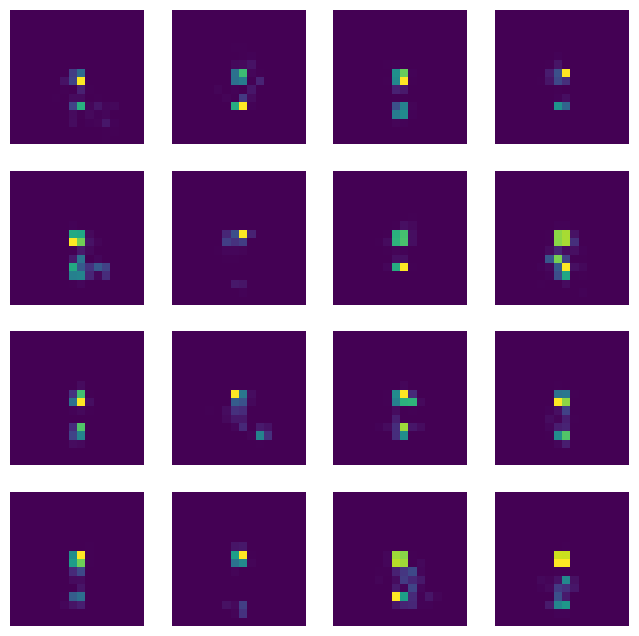

In [ ]:
num_images_to_show = 16
images_to_show = X_jet_resized[:num_images_to_show].squeeze(1).numpy()
plot_images(images_to_show, n_row=4, n_col=4)

## Vanilla GAN

### Architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.init_size = 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Adjust the final linear layer input size based on the output of conv_blocks
        self.fc = nn.Sequential(
            nn.Linear(512 * 1 * 1, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)  # Flatten the output
        validity = self.fc(out)
        return validity


### Training Setup

In [ ]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_epochs = 20

In [ ]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

### Training Loop

In [ ]:
# Training
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    for i, (imgs,) in enumerate(dataloader):

        # Configure input
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        z = torch.randn(imgs.shape[0], latent_dim).to(device)
        fake_imgs = generator(z)

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(device) * 0.9
        fake = torch.zeros(imgs.size(0), 1).to(device)

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()


        optimizer_G.zero_grad()

        fake_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(fake_imgs), valid)

        g_loss.backward()
        optimizer_G.step()
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    epoch_d_loss /= len(dataloader)
    epoch_g_loss /= len(dataloader)

    d_losses.append(epoch_d_loss)
    g_losses.append(epoch_g_loss)

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {epoch_d_loss:.4f}] [G loss: {epoch_g_loss:.4f}]")


[Epoch 1/20] [D loss: 0.2440] [G loss: 4.7379]
[Epoch 2/20] [D loss: 0.1751] [G loss: 6.9815]
[Epoch 3/20] [D loss: 0.1677] [G loss: 7.5781]
[Epoch 4/20] [D loss: 0.1660] [G loss: 8.3221]
[Epoch 5/20] [D loss: 0.1655] [G loss: 8.9710]
[Epoch 6/20] [D loss: 0.1636] [G loss: 10.3588]
[Epoch 7/20] [D loss: 0.1642] [G loss: 11.3176]
[Epoch 8/20] [D loss: 0.1632] [G loss: 11.6459]
[Epoch 9/20] [D loss: 0.1631] [G loss: 12.1818]
[Epoch 10/20] [D loss: 0.1632] [G loss: 13.1303]
[Epoch 11/20] [D loss: 0.1630] [G loss: 13.3474]
[Epoch 12/20] [D loss: 0.1628] [G loss: 13.5320]
[Epoch 13/20] [D loss: 0.1628] [G loss: 14.3613]
[Epoch 14/20] [D loss: 0.1627] [G loss: 14.2810]
[Epoch 15/20] [D loss: 0.1631] [G loss: 15.0026]
[Epoch 16/20] [D loss: 0.1628] [G loss: 16.1273]
[Epoch 17/20] [D loss: 0.1629] [G loss: 17.4029]
[Epoch 18/20] [D loss: 0.1627] [G loss: 17.1635]
[Epoch 19/20] [D loss: 0.1627] [G loss: 17.8069]
[Epoch 20/20] [D loss: 0.1627] [G loss: 18.1919]


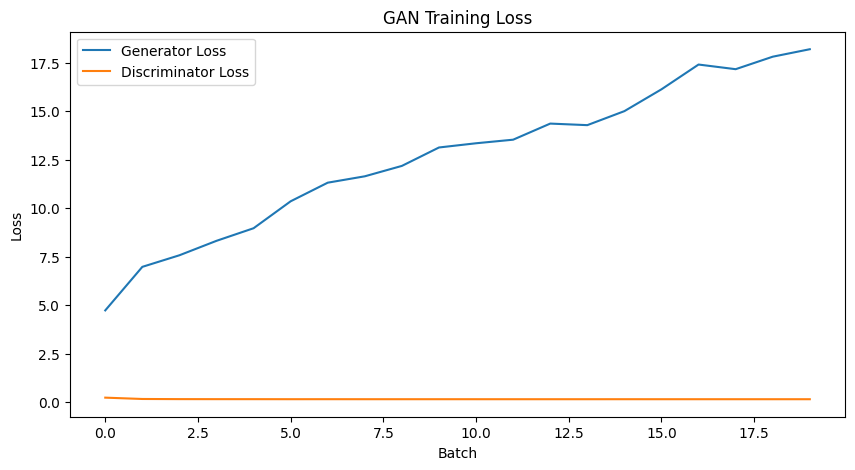

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.show()

# # Plot AUC curve
# plt.figure(figsize=(10, 5))
# plt.plot(aucs, label='AUC')
# plt.xlabel('Epoch')
# plt.ylabel('AUC')
# plt.title('Discriminator AUC Over Epochs')
# plt.legend()
# plt.show()

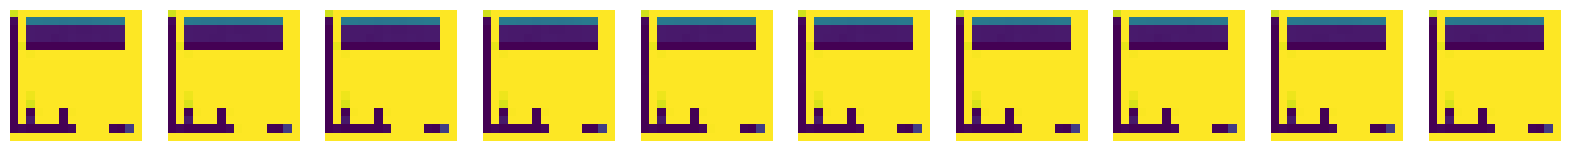

In [ ]:

generator.eval()


with torch.no_grad():

    z = torch.randn(10, latent_dim).to(device)
    generated_imgs = generator(z).cpu()


fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axes[i].imshow(generated_imgs[i].squeeze().numpy())
    axes[i].axis('off')

plt.show()

The vanilla GAN is not complex enough to learn the features, and led to **mode collapse**

## Wesserstein GAN loss

The Wesserstein GAN loss, also known as the Earth-Mover distance (EMD) or Wasserstein distance, aims to measure the distance between the data distribution and the generator distribution in a way that improves training stability and mitigates issues like mode collapse in GANs.

The Wesserstein GAN uses a different approach compared to the traditional GAN loss. Instead of using the sigmoid cross-entropy loss, it employs the Wasserstein distance to provide a meaningful measure of how far the generated data distribution is from the real data distribution. This loss function is used in conjunction with a critic (instead of a discriminator), which approximates the Wasserstein distance.

The Wasserstein distance $W(p_r,p_g)$ between the real data distribution $p_r$ and the generated data distribution $p_g$ is defined as:

$$W(p_r, p_g) = \inf_{\gamma \in \Pi(p_r, p_g)} \mathbb{E}_{(x,y) \sim \gamma} [ \| x - y \| ]$$

where $\Pi(p_r, p_g)$ is the set of all joint distributions $\gamma(x,y)$ whose marginals are $p_r$ and $p_g$


The WGAN loss is

**Critic loss**: $$L_D = \mathbb{E}_{x \sim p_r} [D(x)] - \mathbb{E}_{z \sim p_z} [D(G(z))]$$

**Generator loss**: $$L_G = -\mathbb{E}_{z \sim p_z} [D(G(z))]$$


To enforce the Lipschitz constraint, the gradient penalty is often added:

$$L_D = \mathbb{E}_{x \sim p_r} [D(x)] - \mathbb{E}_{z \sim p_z} [D(G(z))] + \lambda \mathbb{E}_{\hat{x} \sim p_{\hat{x}}} [( \| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1 )^2 ]$$



The Wesserstein GAN loss works well because it provides a smoother and more meaningful gradient signal for training both the generator and the critic. This results in more stable training and better convergence properties. It is used by training the critic to approximate the Wasserstein distance and the generator to minimize this distance.


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            spectral_norm(nn.Linear(128*4*4, 1, bias=False))
        )

    def forward(self, x):
        return self.model(x)

def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def calculate_fid(real_images, fake_images, batch_size=128):
    inception_model = models.inception_v3(pretrained=True, transform_input=False).cuda()
    inception_model.eval()

    def get_features(images):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].cuda()
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.repeat(1, 3, 1, 1)
            with torch.no_grad():
                pred = inception_model(batch)
            features.append(pred.cpu().numpy())
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

latent_dim = 100
lr = 0.0002
n_epochs = 30
lambda_gp = 10

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []
fid_scores = []

In [ ]:
def plot_generated_samples(generator, latent_dim, num_samples=16):
    z = torch.randn(num_samples, latent_dim, 1, 1).cuda()
    gen_samples = generator(z).detach().cpu()
    gen_samples = (gen_samples + 1) / 2.0

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    for i in range(num_samples):
        axes[i].imshow(gen_samples[i, 0])
        axes[i].axis('off')
    plt.show()

def plot_metrics(g_losses, d_losses, fid_scores):
    epochs = range(1, len(g_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, g_losses, label='Generator Loss')
    plt.plot(epochs, d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(fid_scores)), fid_scores, label='FID Score')
    plt.xlabel('Epoch')
    plt.ylabel('FID Score')
    plt.legend()
    plt.title('FID Scores')

    plt.show()

Epoch [0/30] D loss: 0.01753700152039528 G loss: -0.00039711850695312023 FID: 147.4657710851571


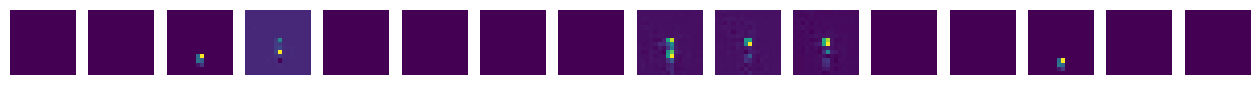

Epoch [1/30] D loss: 0.010704240761697292 G loss: -0.003367033554241061 FID: 149.33315132882976


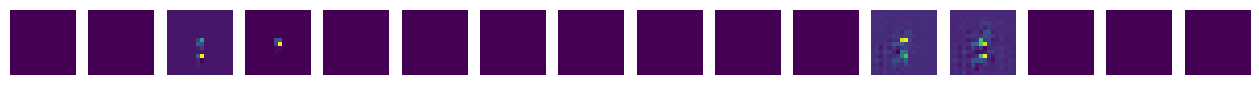

Epoch [2/30] D loss: 0.016169900074601173 G loss: 0.0033620158210396767 FID: 138.71466974391495


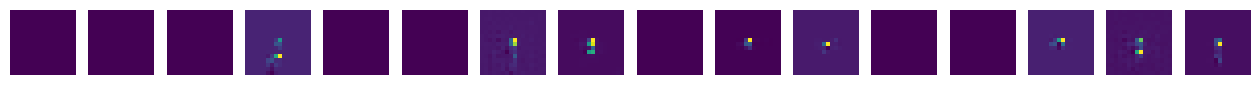

Epoch [3/30] D loss: 0.0481596402823925 G loss: 0.00036575127160176635 FID: 121.79492709101561


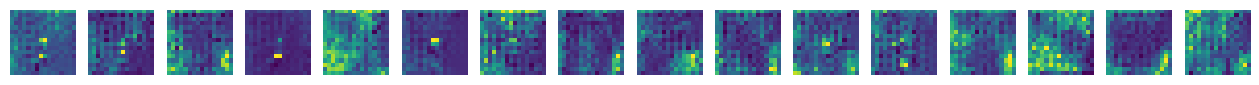

Epoch [4/30] D loss: 0.0229666568338871 G loss: 0.004423126578330994 FID: 120.69457103145783


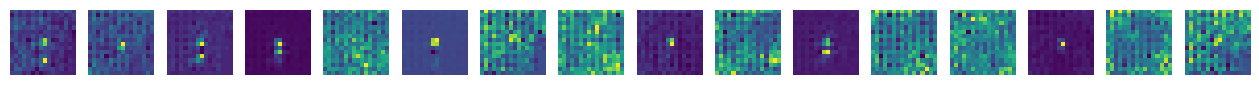

Epoch [5/30] D loss: 0.02104482799768448 G loss: 0.012116072699427605 FID: 144.4590315773999


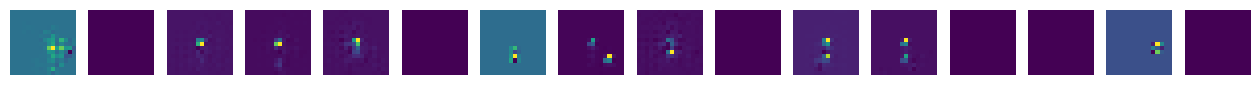

Epoch [6/30] D loss: 0.007879983633756638 G loss: -0.009627556428313255 FID: 138.53737209143327


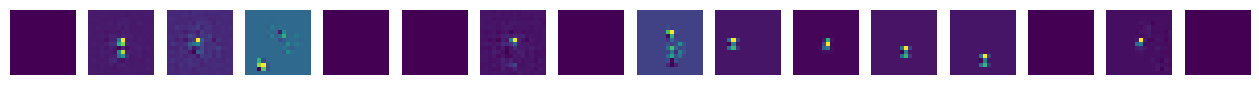

Epoch [7/30] D loss: 0.016330892220139503 G loss: 0.008384913206100464 FID: 130.03748915419095


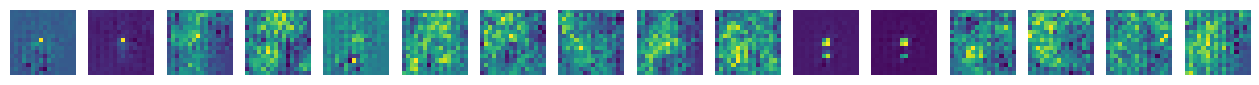

Epoch [8/30] D loss: 0.018755806609988213 G loss: 0.0026928666047751904 FID: 140.8312227229465


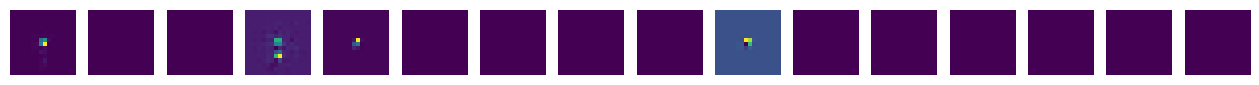

Epoch [9/30] D loss: 0.014931711368262768 G loss: -0.0022038049064576626 FID: 118.94233343051236


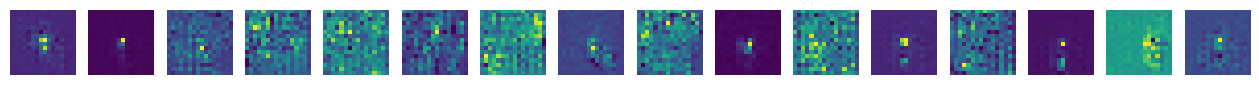

Epoch [10/30] D loss: 0.01625650003552437 G loss: -0.00104747642762959 FID: 146.993241513965


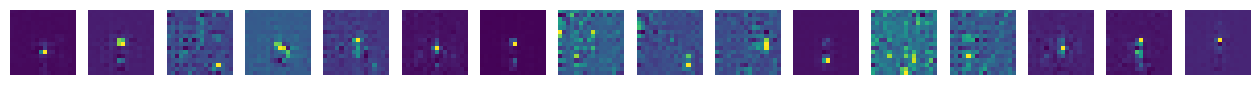

Epoch [11/30] D loss: 0.013399237766861916 G loss: 0.00024222081992775202 FID: 127.79322025650772


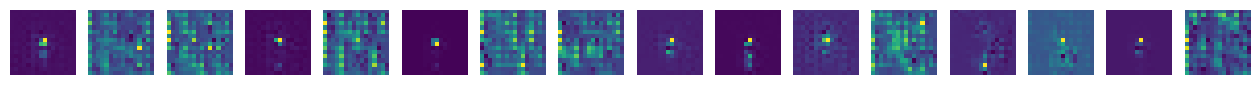

Epoch [12/30] D loss: 0.013619538396596909 G loss: -0.003519500372931361 FID: 131.9352930616713


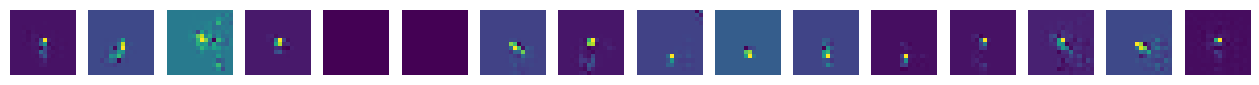

Epoch [13/30] D loss: 0.016859227791428566 G loss: 0.0018741060048341751 FID: 139.8798751138106


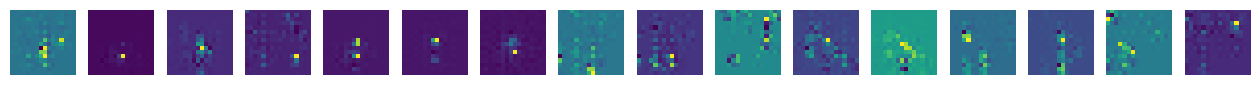

Epoch [14/30] D loss: 0.014344315975904465 G loss: -0.0011154039530083537 FID: 131.9619167956369


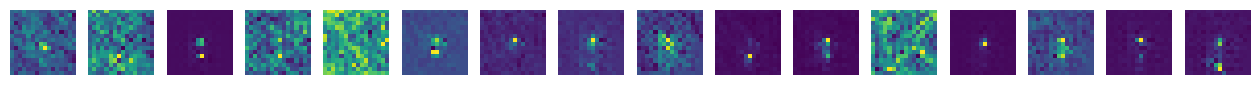

Epoch [15/30] D loss: 0.010797476395964622 G loss: -0.0016459889011457562 FID: 151.1200956400714


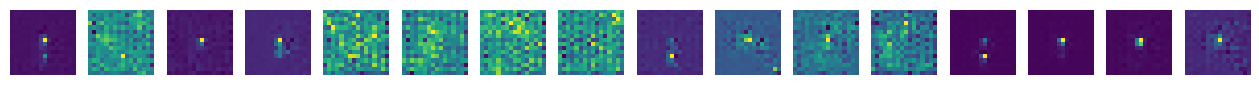

Epoch [16/30] D loss: 0.013275094330310822 G loss: 0.00185118755325675 FID: 123.84599201334287


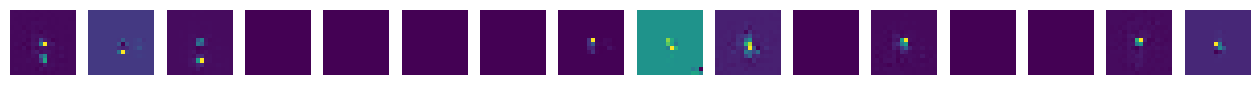

Epoch [17/30] D loss: 0.023855868726968765 G loss: -0.005416975822299719 FID: 143.62254809336102


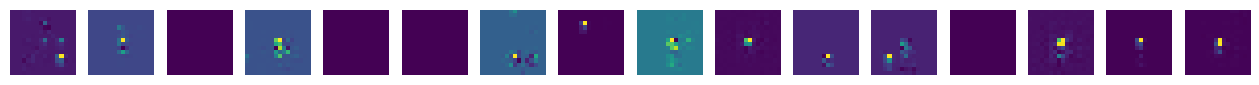

Epoch [18/30] D loss: 0.009836881421506405 G loss: 0.002455088309943676 FID: 130.41447002572093


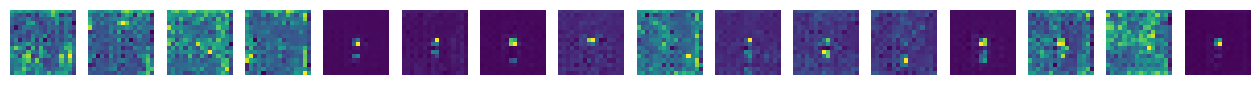

Epoch [19/30] D loss: 0.008819002658128738 G loss: 0.0021397401578724384 FID: 132.53546693780902


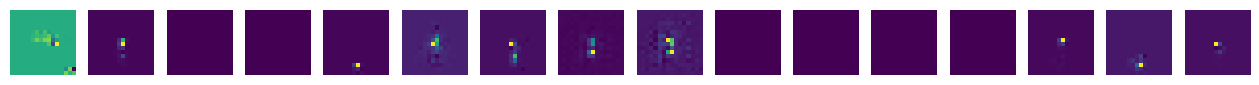

Epoch [20/30] D loss: 0.01705285534262657 G loss: -0.005969432182610035 FID: 126.29157932491091


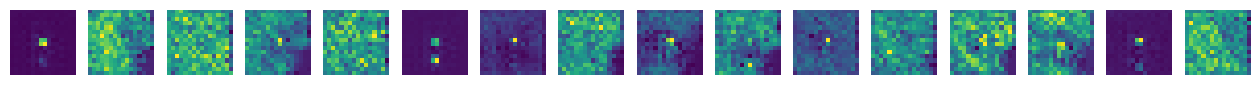

Epoch [21/30] D loss: 0.014779409393668175 G loss: -0.006645251996815205 FID: 128.96408615929735


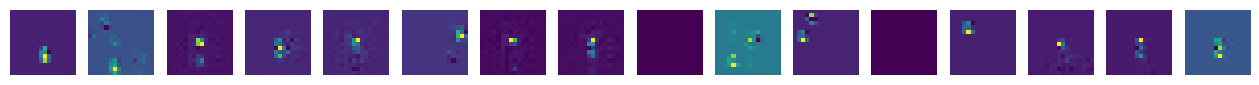

Epoch [22/30] D loss: 0.011133362539112568 G loss: 0.000734636327251792 FID: 115.80756976144704


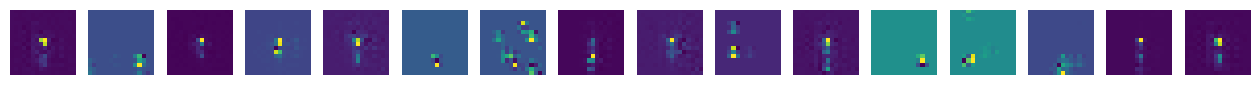

Epoch [23/30] D loss: 0.016523951664566994 G loss: 0.0016251164488494396 FID: 135.69883309472488


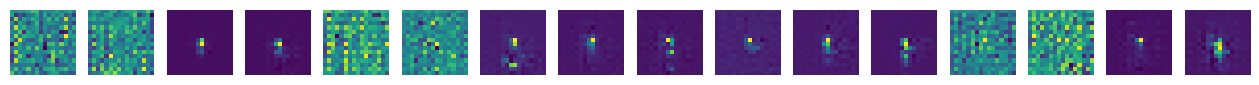

Epoch [24/30] D loss: 0.01392835658043623 G loss: 0.0035850515123456717 FID: 128.09346289469556


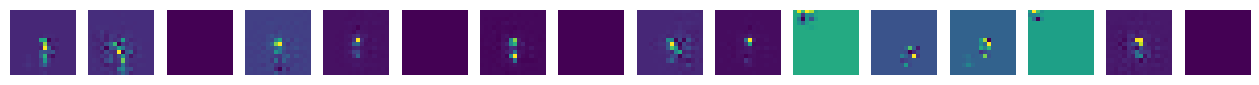

Epoch [25/30] D loss: 0.007052324712276459 G loss: 0.0015012931544333696 FID: 127.55825026252529


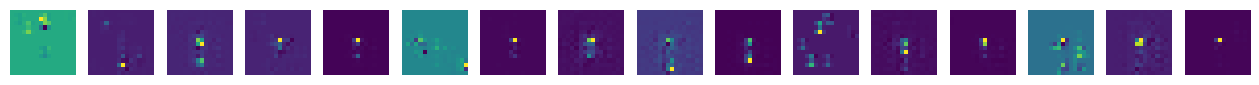

Epoch [26/30] D loss: 0.015963595360517502 G loss: -0.003184715285897255 FID: 112.14295291248652


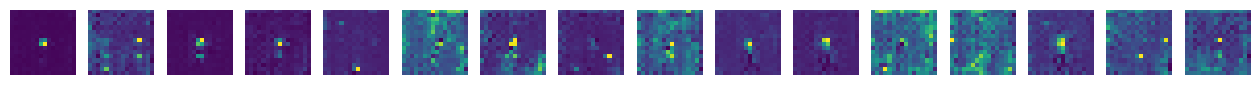

Epoch [27/30] D loss: 0.015117445029318333 G loss: 0.0031332490034401417 FID: 132.5621034889292


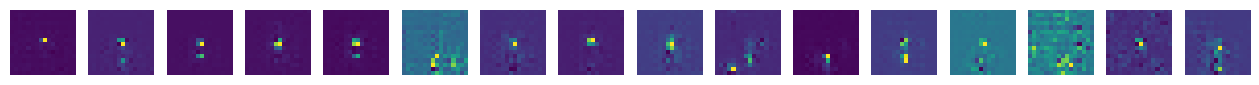

Epoch [28/30] D loss: 0.0059842756018042564 G loss: 0.006567572709172964 FID: 123.04718961652321


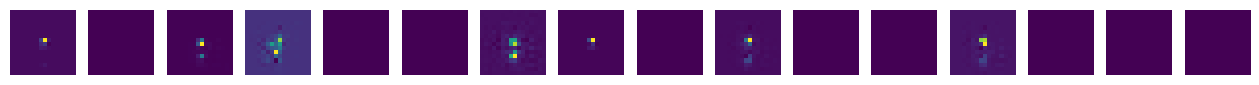

Epoch [29/30] D loss: 0.011428778991103172 G loss: -0.0003950734972022474 FID: 128.36041856881616


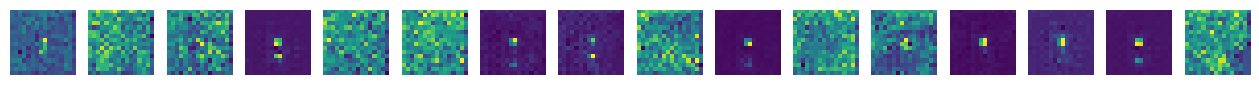

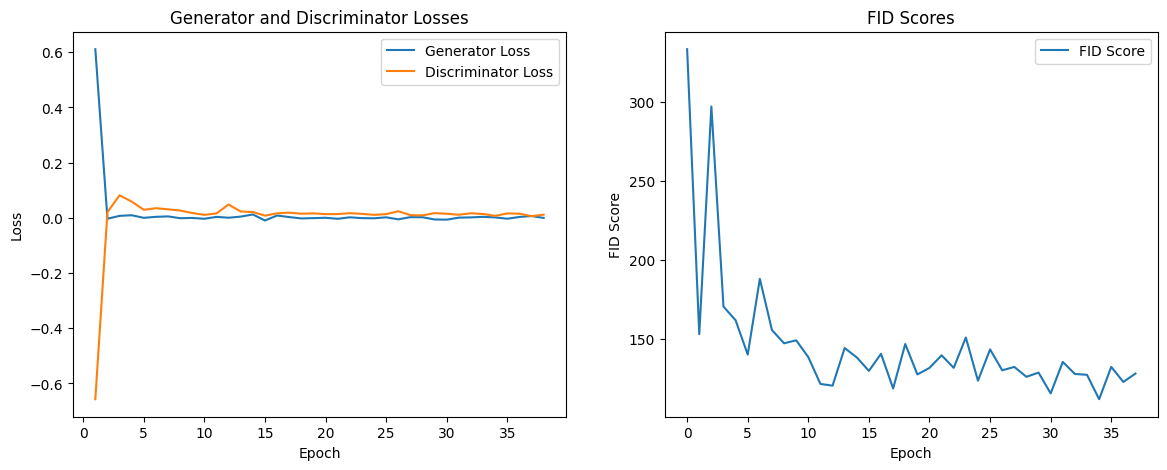

In [ ]:

for epoch in range(n_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        real_samples = real_samples.cuda()
        batch_size = real_samples.size(0)

        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_samples = generator(z).detach()
        real_validity = discriminator(real_samples)
        fake_validity = discriminator(fake_samples)

        gp = gradient_penalty(discriminator, real_samples, fake_samples)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        if i % 5 == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
            gen_samples = generator(z)
            gen_validity = discriminator(gen_samples)
            g_loss = -torch.mean(gen_validity)

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    z = torch.randn(1000, latent_dim, 1, 1).cuda()
    fake_images = generator(z).detach().cpu()
    real_images = next(iter(dataloader))[0][:1000].cpu()

    fid = calculate_fid(real_images, fake_images, batch_size=batch_size)
    fid_scores.append(fid)
    print(f"Epoch [{epoch}/{n_epochs}] D loss: {d_loss.item()} G loss: {g_loss.item()} FID: {fid}")

    output_image = fake_images[:16]  # Save 16 generated samples
    output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    grid = torchvision.utils.make_grid(output_image, nrow=4, normalize=True)
    np_img = grid.permute(1, 2, 0).numpy()
    plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, latent_dim)

plot_metrics(g_losses, d_losses, fid_scores)

In [ ]:
print(g_losses)

[0.6107698082923889, -0.0032584592700004578, 0.007202049717307091, 0.009340459480881691, -3.1654628401156515e-05, 0.0036031906493008137, 0.005210882052779198, -0.0013657687231898308, -0.00039711850695312023, -0.003367033554241061, 0.0033620158210396767, 0.00036575127160176635, 0.004423126578330994, 0.012116072699427605, -0.009627556428313255, 0.008384913206100464, 0.0026928666047751904, -0.0022038049064576626, -0.00104747642762959, 0.00024222081992775202, -0.003519500372931361, 0.0018741060048341751, -0.0011154039530083537, -0.0016459889011457562, 0.00185118755325675, -0.005416975822299719, 0.002455088309943676, 0.0021397401578724384, -0.005969432182610035, -0.006645251996815205, 0.000734636327251792, 0.0016251164488494396, 0.0035850515123456717, 0.0015012931544333696, -0.003184715285897255, 0.0031332490034401417, 0.006567572709172964, -0.0003950734972022474]


In [ ]:
print(d_losses)

[-0.6570994853973389, 0.020365366712212563, 0.08161641657352448, 0.058794353157281876, 0.029149062931537628, 0.03486768528819084, 0.03091558814048767, 0.02634391374886036, 0.01753700152039528, 0.010704240761697292, 0.016169900074601173, 0.0481596402823925, 0.0229666568338871, 0.02104482799768448, 0.007879983633756638, 0.016330892220139503, 0.018755806609988213, 0.014931711368262768, 0.01625650003552437, 0.013399237766861916, 0.013619538396596909, 0.016859227791428566, 0.014344315975904465, 0.010797476395964622, 0.013275094330310822, 0.023855868726968765, 0.009836881421506405, 0.008819002658128738, 0.01705285534262657, 0.014779409393668175, 0.011133362539112568, 0.016523951664566994, 0.01392835658043623, 0.007052324712276459, 0.015963595360517502, 0.015117445029318333, 0.0059842756018042564, 0.011428778991103172]


In [ ]:
print(fid_scores)

[333.1911897667818, 153.27312246885305, 296.9973182672774, 170.63824880684817, 161.99708933680628, 140.34227284630165, 188.16404164779698, 155.8117610087724, 147.4657710851571, 149.33315132882976, 138.71466974391495, 121.79492709101561, 120.69457103145783, 144.4590315773999, 138.53737209143327, 130.03748915419095, 140.8312227229465, 118.94233343051236, 146.993241513965, 127.79322025650772, 131.9352930616713, 139.8798751138106, 131.9619167956369, 151.1200956400714, 123.84599201334287, 143.62254809336102, 130.41447002572093, 132.53546693780902, 126.29157932491091, 128.96408615929735, 115.80756976144704, 135.69883309472488, 128.09346289469556, 127.55825026252529, 112.14295291248652, 132.5621034889292, 123.04718961652321, 128.36041856881616]


## Total Variation Loss

Total Variation (TV) loss is used to reduce noise and encourage smoothness in the generated images. It penalizes the differences between neighboring pixel values.

The TV loss works by minimizing the sum of the absolute differences between neighboring pixel values in the generated image. This encourages the image to have regions with smooth intensity transitions, thereby reducing noise.

For an Image $I$ with dimentions $H$ x $W$, the total variation loss $L_{TV}$ is given by:

$$L_{TV}(I) = \sum_{i=1}^{H-1} \sum_{j=1}^{W-1} \left( (I_{i,j} - I_{i+1,j})^2 + (I_{i,j} - I_{i,j+1})^2 \right)$$


Total Variation loss works in GANs by promoting smoothness in the generated images, thereby reducing artifacts and noise. It is often added as an additional regularization term to the generator's loss function.


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            spectral_norm(nn.Linear(128*4*4, 1, bias=False))
        )

    def forward(self, x):
        return self.model(x)

def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def total_variation_loss(img):
    batch_size = img.size(0)
    h_x = img.size(2)
    w_x = img.size(3)
    count_h = (img.size(2) - 1) * img.size(3)
    count_w = img.size(2) * (img.size(3) - 1)
    h_tv = torch.pow((img[:,:,1:,:] - img[:,:,:h_x-1,:]), 2).sum()
    w_tv = torch.pow((img[:,:,:,1:] - img[:,:,:,:w_x-1]), 2).sum()
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

def calculate_fid(real_images, fake_images, batch_size=128):
    inception_model = models.inception_v3(pretrained=True, transform_input=False).cuda()
    inception_model.eval()

    def get_features(images):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].cuda()
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.repeat(1, 3, 1, 1)
            with torch.no_grad():
                pred = inception_model(batch)
            features.append(pred.cpu().numpy())
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

latent_dim = 100
lr = 0.0002
n_epochs = 30
lambda_gp = 10
lambda_tv = 1  #

In [ ]:
generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []
fid_scores = []


Epoch [0/30] D loss: 0.08361802250146866 G loss: 0.00693859625607729 FID: 170.40042342256592


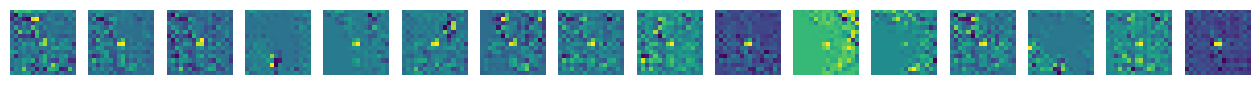

Epoch [1/30] D loss: 0.041083160787820816 G loss: 0.0015545561909675598 FID: 81.45906032930336


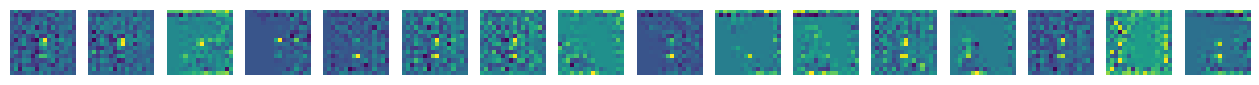

Epoch [2/30] D loss: 0.033602286130189896 G loss: -0.0012267464771866798 FID: 52.7562536493803


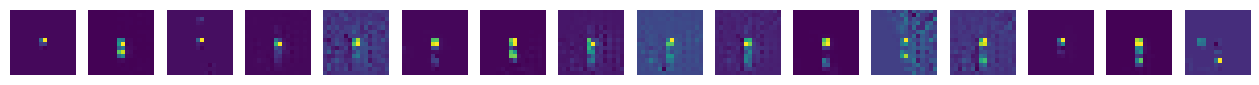

Epoch [3/30] D loss: 0.0359027199447155 G loss: -8.769982377998531e-05 FID: 49.46532408291688


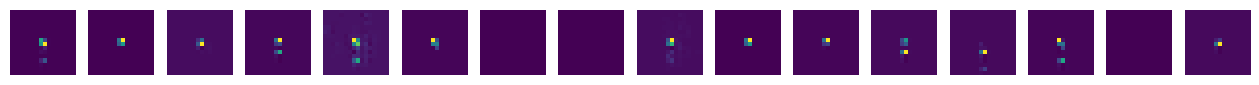

Epoch [4/30] D loss: 0.021906977519392967 G loss: -0.002471219515427947 FID: 31.02080699957505


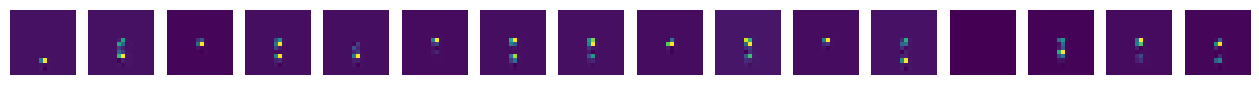

Epoch [5/30] D loss: 0.017222529277205467 G loss: -0.0015298135112971067 FID: 22.372233184290877


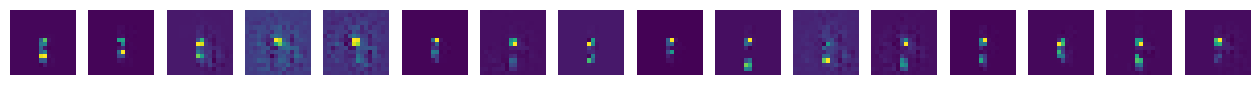

Epoch [6/30] D loss: 0.025619374588131905 G loss: -3.296078648418188e-05 FID: 28.672336419038412


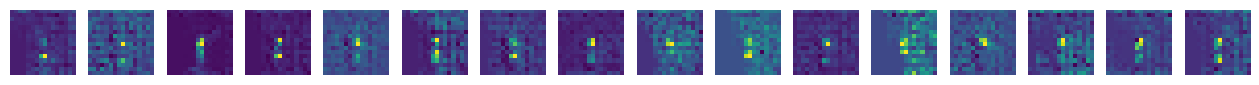

Epoch [7/30] D loss: 0.014846219681203365 G loss: -0.0016971906879916787 FID: 31.87648374836182


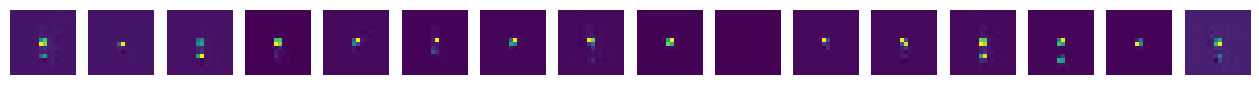

Epoch [8/30] D loss: 0.01744651608169079 G loss: -0.0009153661667369306 FID: 25.29253863937702


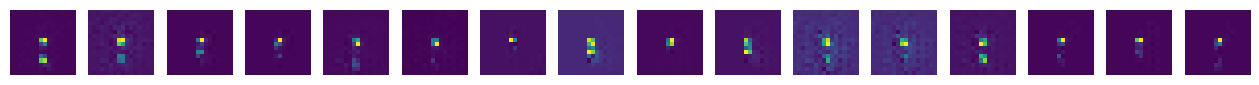

Epoch [9/30] D loss: 0.007712512742727995 G loss: 0.0012806321028620005 FID: 21.20304659733309


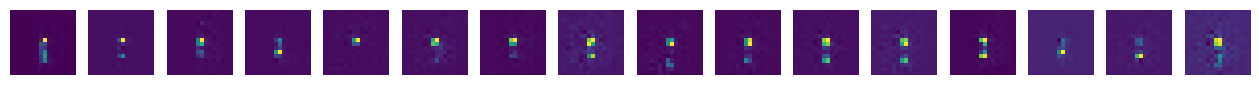

Epoch [10/30] D loss: 0.012956246733665466 G loss: -0.0005023071425966918 FID: 16.227318325759


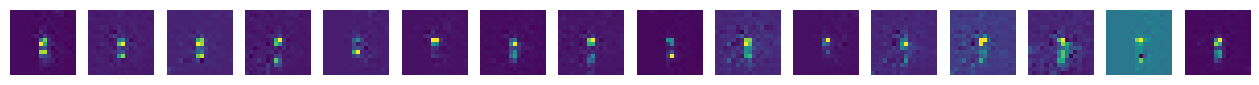

Epoch [11/30] D loss: 0.013128122314810753 G loss: -0.0012246475089341402 FID: 27.48023886486733


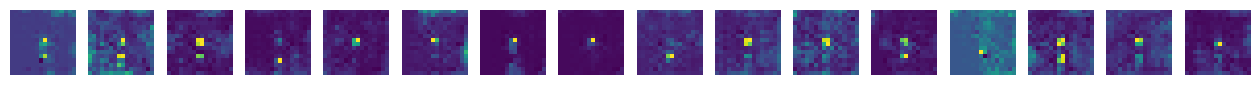

Epoch [12/30] D loss: 0.01050667092204094 G loss: 8.550647180527449e-05 FID: 11.77344673609371


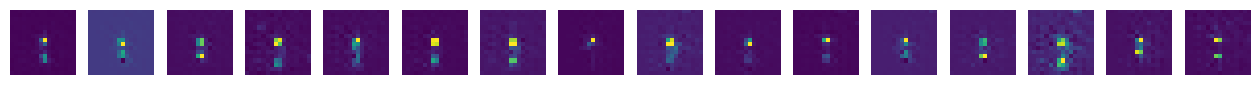

Epoch [13/30] D loss: 0.010704762302339077 G loss: 0.00033427681773900986 FID: 24.47349021833594


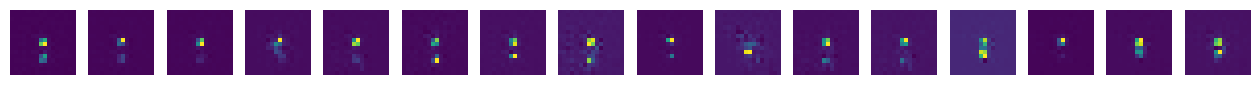

Epoch [14/30] D loss: 0.008477533236145973 G loss: -0.00031758780824020505 FID: 16.045312976949518


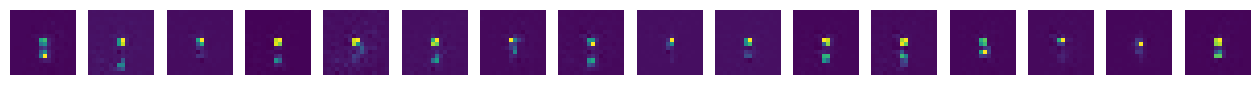

Epoch [15/30] D loss: 0.009597467258572578 G loss: -3.4837896237149835e-05 FID: 9.757235098477256


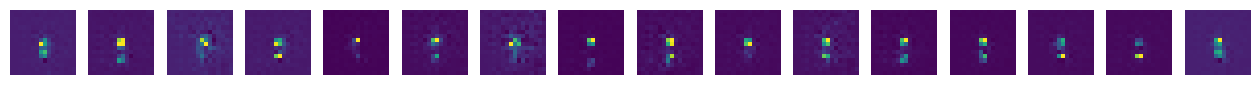

Epoch [16/30] D loss: 0.007669096812605858 G loss: -0.0007113100728020072 FID: 13.885136749328787


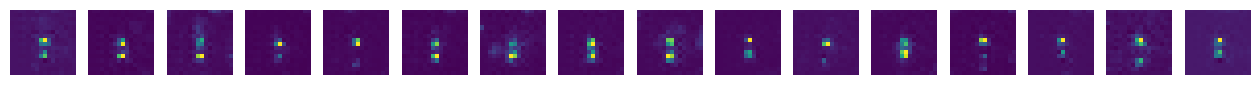

Epoch [17/30] D loss: 0.011142768897116184 G loss: 0.004342529457062483 FID: 9.264602931442925


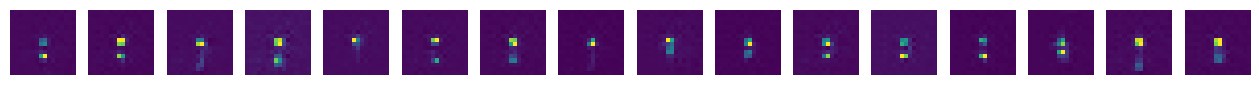

Epoch [18/30] D loss: 0.009614624083042145 G loss: -0.0010913971345871687 FID: 8.79997327689673


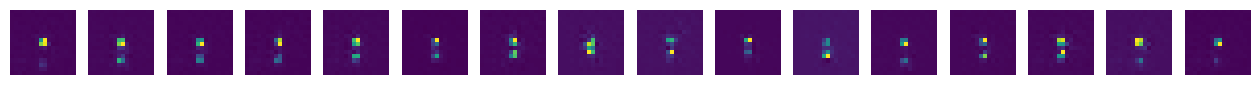

Epoch [19/30] D loss: 0.009258274920284748 G loss: -0.0036845565773546696 FID: 10.950744780628344


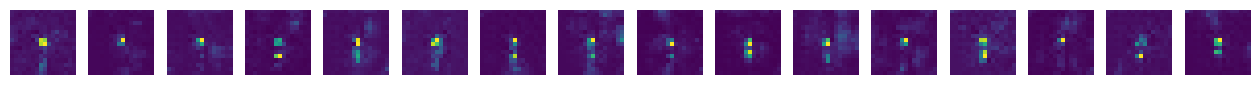

Epoch [20/30] D loss: 0.006303764879703522 G loss: -0.00018685180111788213 FID: 11.80677839700365


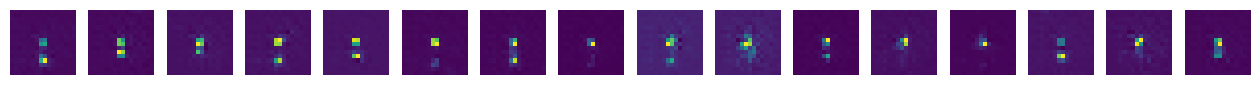

Epoch [21/30] D loss: 0.007071893196552992 G loss: -3.987879608757794e-05 FID: 9.079796138282399


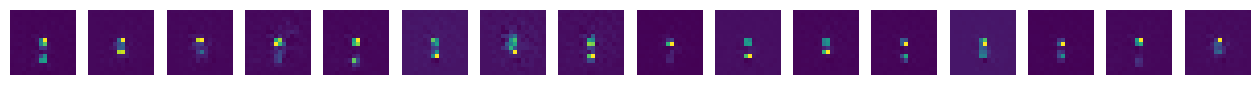

Epoch [22/30] D loss: 0.011132261715829372 G loss: 0.0023532339837402105 FID: 35.81281417080922


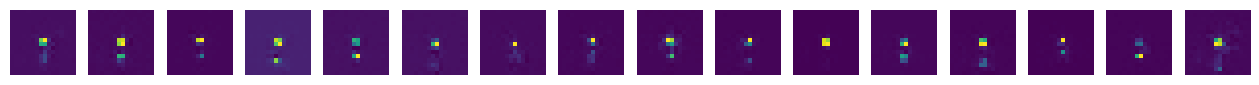

Epoch [23/30] D loss: 0.008194860070943832 G loss: -0.0018733040196821094 FID: 19.80163250084465


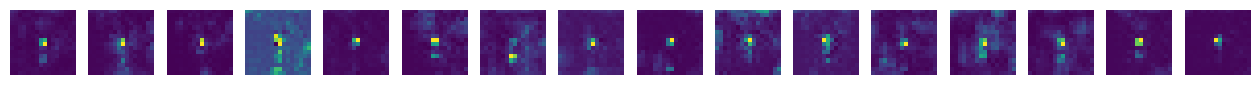

Epoch [24/30] D loss: 0.01092322263866663 G loss: -0.0006471812375821173 FID: 7.923712091498351


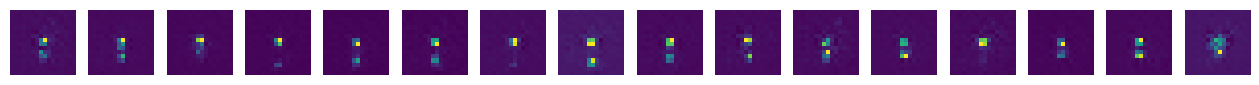

Epoch [25/30] D loss: 0.006595422979444265 G loss: 0.0005925933364778757 FID: 8.473825354244326


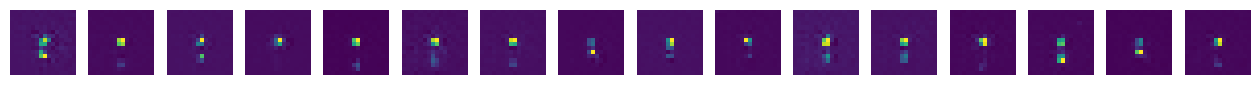

Epoch [26/30] D loss: 0.00850335881114006 G loss: 0.003005924867466092 FID: 8.272785830979679


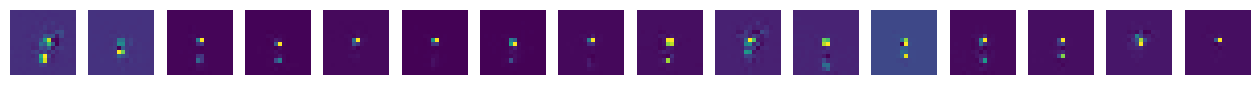

Epoch [27/30] D loss: 0.008105496875941753 G loss: -0.0010757878189906478 FID: 12.426985258587088


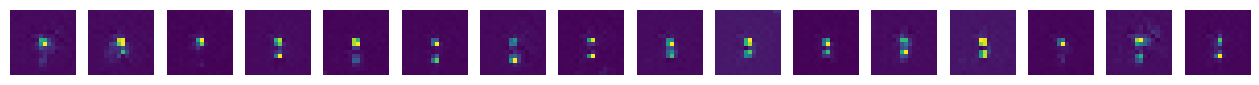

Epoch [28/30] D loss: 0.010413737036287785 G loss: -0.0018723179819062352 FID: 8.915622098792014


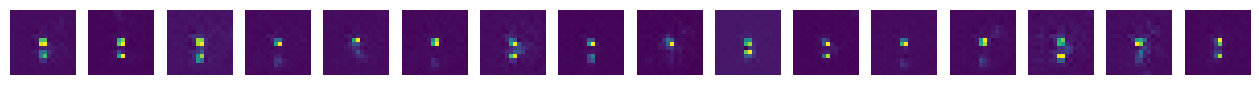

Epoch [29/30] D loss: 0.005852528847754002 G loss: 0.001528839347884059 FID: 14.207173302188771


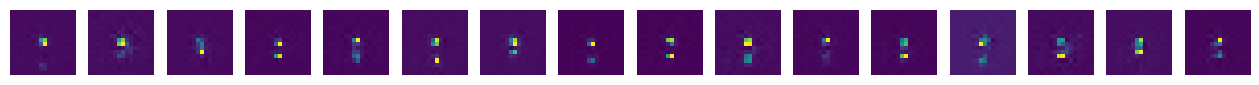

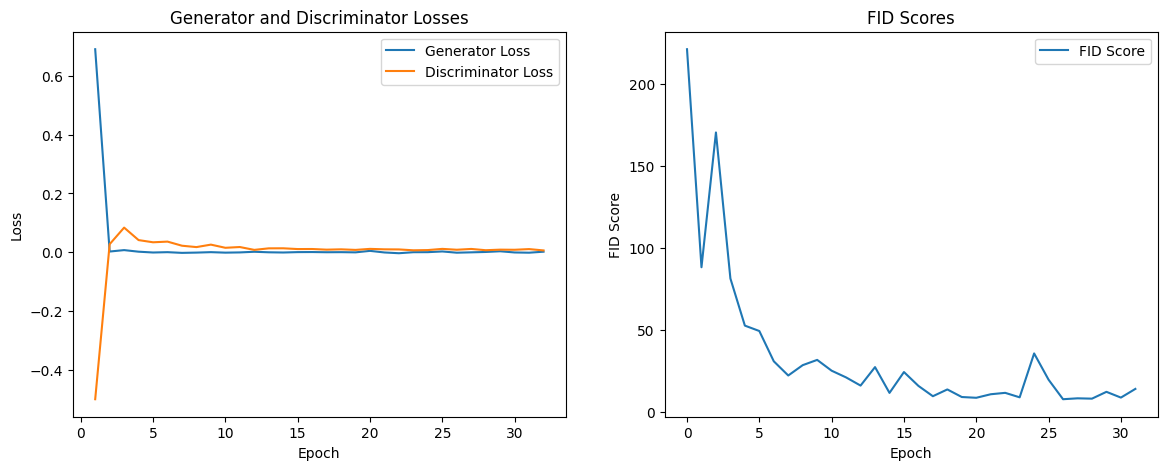

In [ ]:
for epoch in range(n_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        real_samples = real_samples.cuda()
        batch_size = real_samples.size(0)

        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_samples = generator(z).detach()
        real_validity = discriminator(real_samples)
        fake_validity = discriminator(fake_samples)

        gp = gradient_penalty(discriminator, real_samples, fake_samples)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        if i % 5 == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
            gen_samples = generator(z)
            gen_validity = discriminator(gen_samples)

            tv_loss = total_variation_loss(gen_samples)
            g_loss = -torch.mean(gen_validity) + lambda_tv * tv_loss

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    z = torch.randn(1000, latent_dim, 1, 1).cuda()
    fake_images = generator(z).detach().cpu()
    real_images = next(iter(dataloader))[0][:1000].cpu()

    fid = calculate_fid(real_images, fake_images, batch_size=batch_size)
    fid_scores.append(fid)
    print(f"Epoch [{epoch}/{n_epochs}] D loss: {d_loss.item()} G loss: {g_loss.item()} FID: {fid}")

    # Save generated images every epoch
    output_image = fake_images[:16]  # Save 16 generated samples
    output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    grid = torchvision.utils.make_grid(output_image, nrow=4)
    np_img = grid.numpy().transpose((1, 2, 0))
    plt.imsave(f'classical_Jet_image_TV_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, latent_dim)

plot_metrics(g_losses, d_losses, fid_scores)


In [ ]:
print(g_losses)

[0.6916328072547913, 0.002085713669657707, 0.00693859625607729, 0.0015545561909675598, -0.0012267464771866798, -8.769982377998531e-05, -0.002471219515427947, -0.0015298135112971067, -3.296078648418188e-05, -0.0016971906879916787, -0.0009153661667369306, 0.0012806321028620005, -0.0005023071425966918, -0.0012246475089341402, 8.550647180527449e-05, 0.00033427681773900986, -0.00031758780824020505, -3.4837896237149835e-05, -0.0007113100728020072, 0.004342529457062483, -0.0010913971345871687, -0.0036845565773546696, -0.00018685180111788213, -3.987879608757794e-05, 0.0023532339837402105, -0.0018733040196821094, -0.0006471812375821173, 0.0005925933364778757, 0.003005924867466092, -0.0010757878189906478, -0.0018723179819062352, 0.001528839347884059]


In [ ]:
print(d_losses)

[-0.5012829899787903, 0.027131594717502594, 0.08361802250146866, 0.041083160787820816, 0.033602286130189896, 0.0359027199447155, 0.021906977519392967, 0.017222529277205467, 0.025619374588131905, 0.014846219681203365, 0.01744651608169079, 0.007712512742727995, 0.012956246733665466, 0.013128122314810753, 0.01050667092204094, 0.010704762302339077, 0.008477533236145973, 0.009597467258572578, 0.007669096812605858, 0.011142768897116184, 0.009614624083042145, 0.009258274920284748, 0.006303764879703522, 0.007071893196552992, 0.011132261715829372, 0.008194860070943832, 0.01092322263866663, 0.006595422979444265, 0.00850335881114006, 0.008105496875941753, 0.010413737036287785, 0.005852528847754002]


In [ ]:
print(fid_scores)

[221.09343924825785, 88.30213498117544, 170.40042342256592, 81.45906032930336, 52.7562536493803, 49.46532408291688, 31.02080699957505, 22.372233184290877, 28.672336419038412, 31.87648374836182, 25.29253863937702, 21.20304659733309, 16.227318325759, 27.48023886486733, 11.77344673609371, 24.47349021833594, 16.045312976949518, 9.757235098477256, 13.885136749328787, 9.264602931442925, 8.79997327689673, 10.950744780628344, 11.80677839700365, 9.079796138282399, 35.81281417080922, 19.80163250084465, 7.923712091498351, 8.473825354244326, 8.272785830979679, 12.426985258587088, 8.915622098792014, 14.207173302188771]


## Perceptual loss

Perceptual loss, also known as content loss or feature loss, measures the difference between high-level feature representations of the real and generated images as extracted by a pre-trained network, typically a convolutional neural network (CNN) like VGG.

The perceptual loss works by comparing feature maps obtained from intermediate layers of a pre-trained network for both the real and generated images. This helps in capturing perceptually relevant differences that are not well captured by pixel-wise losses like L2.

Given a pre-trained network
𝜙 and layers $l$
in the network, the perceptual loss $L_{perc}$ is defined as:
$$L_{perc}(I_r, I_g) = \sum_{l} \lambda_l \| \phi_l(I_r) - \phi_l(I_g) \|_2^2$$

where $I_r$ and $I_g$ are the real and generated images, respectively, and $λ_l$ are the weights for the contributions of different layers.

Perceptual loss works in GANs by encouraging the generator to produce images that are not only close to the real images in pixel space but also in feature space, leading to more visually appealing results.


In [ ]:
vgg = models.vgg16(pretrained=True).features[:16].cuda().eval()
for param in vgg.parameters():
    param.requires_grad = False

C:\Users\adith\anaconda3\envs\gsoc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\adith\anaconda3\envs\gsoc\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            spectral_norm(nn.Linear(128*4*4, 1, bias=False))
        )

    def forward(self, x):
        return self.model(x)

def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def perceptual_loss(real, fake, vgg):
    real_features = vgg(real.repeat(1, 3, 1, 1))  # Repeat channels to match VGG input
    fake_features = vgg(fake.repeat(1, 3, 1, 1))
    loss = F.mse_loss(fake_features, real_features)
    return loss

def calculate_fid(real_images, fake_images, batch_size=128):
    inception_model = models.inception_v3(pretrained=True, transform_input=False).cuda()
    inception_model.eval()

    def get_features(images):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].cuda()
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.repeat(1, 3, 1, 1)
            with torch.no_grad():
                pred = inception_model(batch)
            features.append(pred.cpu().numpy())
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

latent_dim = 100
lr = 0.0002
n_epochs = 30
lambda_gp = 10
lambda_perceptual = 1  # Weight for the perceptual loss term

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()
vgg = models.vgg16(pretrained=True).features[:16].cuda().eval()
for param in vgg.parameters():
    param.requires_grad = False

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []
fid_scores = []


Epoch [0/30] D loss: 0.022201072424650192 G loss: 0.1057906374335289 FID: 36.937361824919506


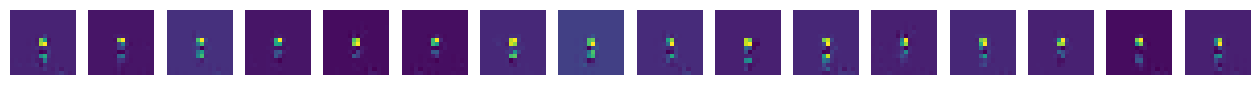

Epoch [1/30] D loss: 0.011528827250003815 G loss: 0.1269603967666626 FID: 59.07270770079462


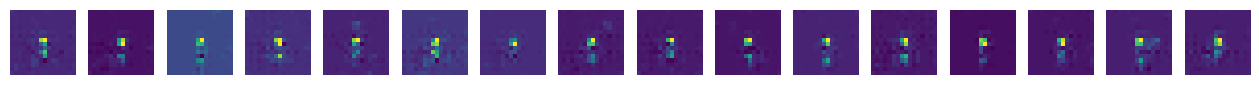

Epoch [2/30] D loss: 0.013483656570315361 G loss: 0.12733033299446106 FID: 52.065108430882695


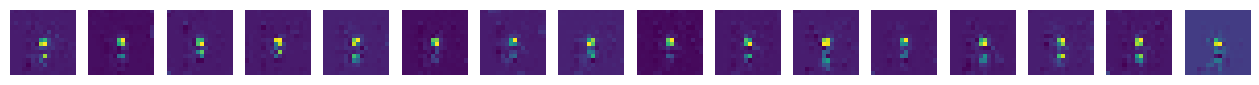

Epoch [3/30] D loss: 0.0034656506031751633 G loss: 0.11718712747097015 FID: 46.583540864392134


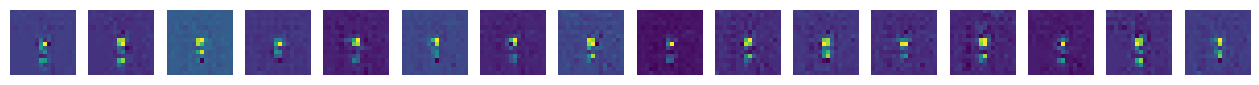

Epoch [4/30] D loss: 0.01884545385837555 G loss: 0.15081068873405457 FID: 39.280521779554185


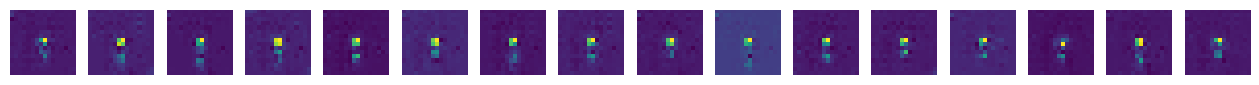

Epoch [5/30] D loss: 0.016884570941329002 G loss: 0.11949610710144043 FID: 39.35491269844282


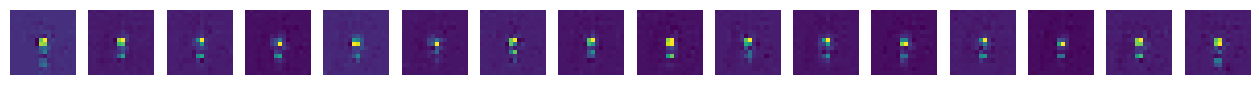

Epoch [6/30] D loss: 0.015200324356555939 G loss: 0.10735379904508591 FID: 55.92528615764331


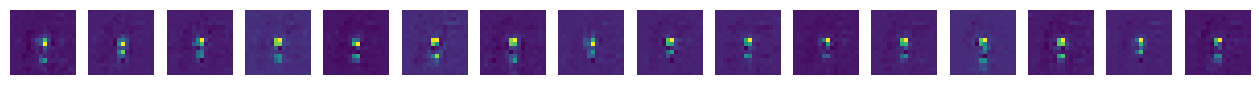

Epoch [7/30] D loss: 0.00404078233987093 G loss: 0.0955270528793335 FID: 51.82118601924279


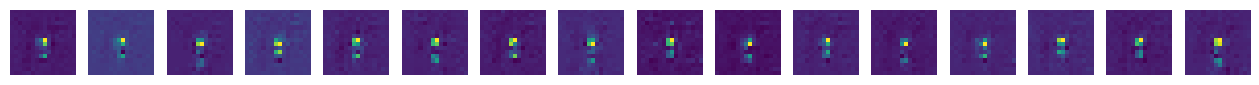

Epoch [8/30] D loss: 0.011140875518321991 G loss: 0.1100112646818161 FID: 61.11137154575812


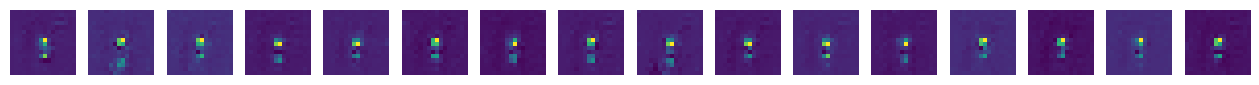

Epoch [9/30] D loss: 0.008812189102172852 G loss: 0.10077296197414398 FID: 43.2616763239873


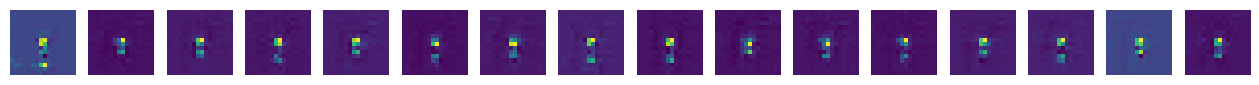

Epoch [10/30] D loss: 0.020161917433142662 G loss: 0.10373788326978683 FID: 54.94483713835481


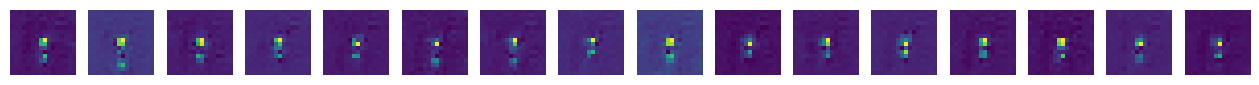

Epoch [11/30] D loss: 0.014915596693754196 G loss: 0.07943941652774811 FID: 38.65162494317748


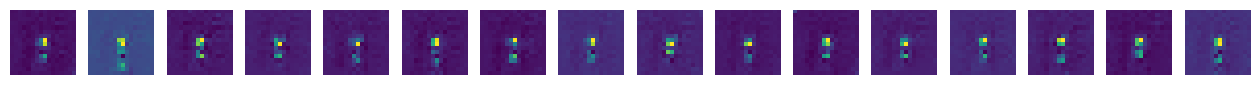

Epoch [12/30] D loss: 0.009316431358456612 G loss: 0.08601066470146179 FID: 56.73430859755508


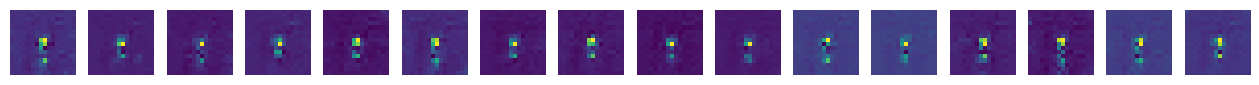

Epoch [13/30] D loss: 0.009974295273423195 G loss: 0.10428385436534882 FID: 37.649287120646235


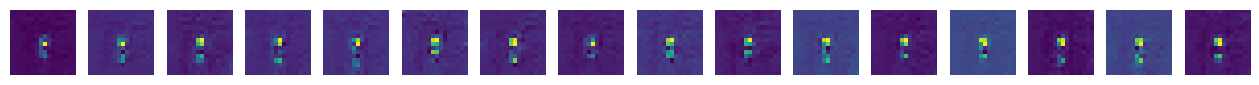

Epoch [14/30] D loss: 0.008916618302464485 G loss: 0.0871211513876915 FID: 39.727142671193306


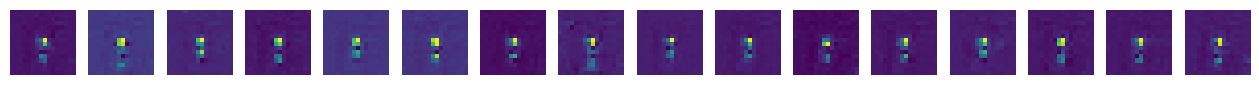

Epoch [15/30] D loss: 0.011644646525382996 G loss: 0.08580352365970612 FID: 36.98009678022985


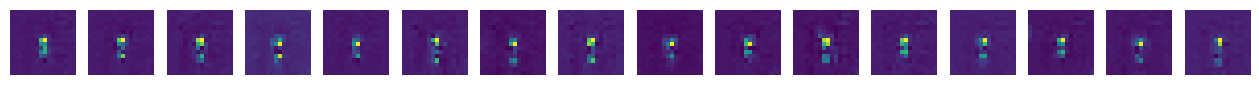

Epoch [16/30] D loss: 0.00693508330732584 G loss: 0.10494780540466309 FID: 43.73012347297779


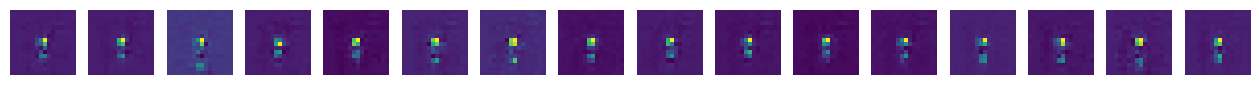

Epoch [17/30] D loss: 0.0033889692276716232 G loss: 0.10182353109121323 FID: 68.74605952607297


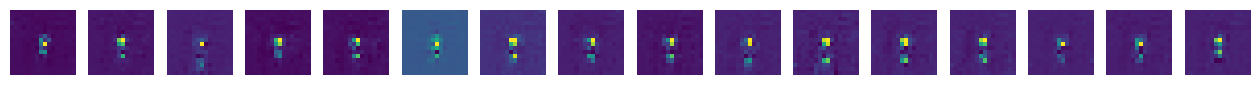

Epoch [18/30] D loss: 0.00671355240046978 G loss: 0.09140593558549881 FID: 37.97443021600215


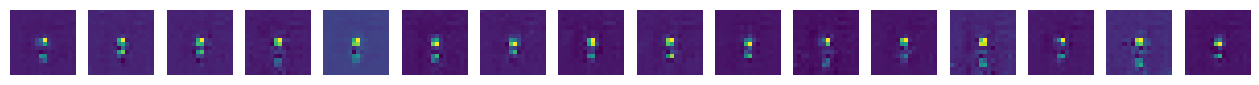

Epoch [19/30] D loss: 0.00853161420673132 G loss: 0.11170253157615662 FID: 66.19820403303244


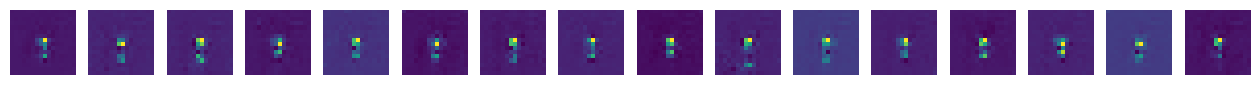

Epoch [20/30] D loss: 0.005797534249722958 G loss: 0.0969151183962822 FID: 44.98999316515746


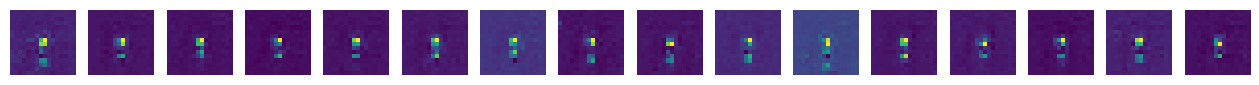

Epoch [21/30] D loss: 0.008319198153913021 G loss: 0.1096348986029625 FID: 70.47978646325072


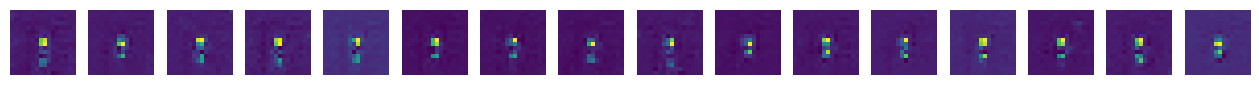

Epoch [22/30] D loss: 0.008024481125175953 G loss: 0.10859175026416779 FID: 47.834641736795035


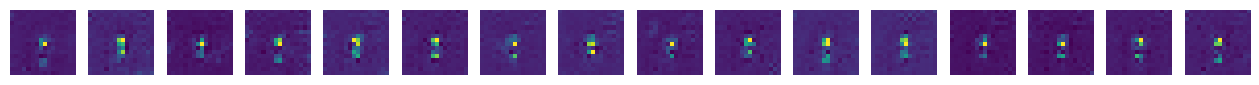

Epoch [23/30] D loss: 0.009456687606871128 G loss: 0.09852977097034454 FID: 42.70155320505098


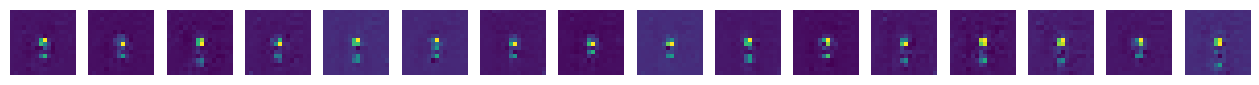

Epoch [24/30] D loss: 0.005019264295697212 G loss: 0.0959799587726593 FID: 42.79210296480596


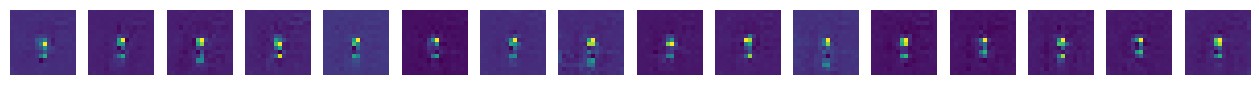

Epoch [25/30] D loss: 0.012477556243538857 G loss: 0.09238947927951813 FID: 43.9311703108076


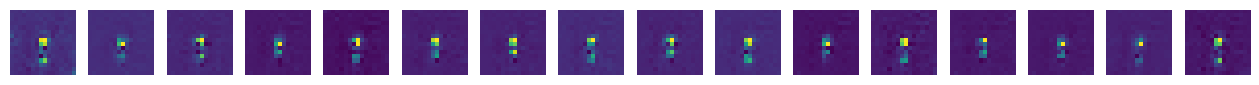

Epoch [26/30] D loss: 0.0027123205363750458 G loss: 0.10717003047466278 FID: 57.97148157818546


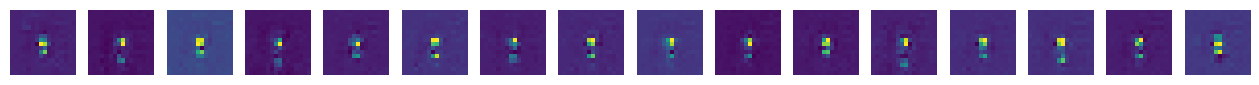

Epoch [27/30] D loss: 0.004894208163022995 G loss: 0.09768899530172348 FID: 58.323054822194415


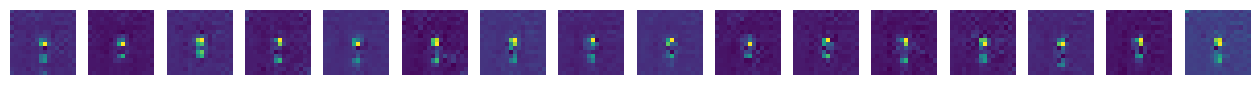

Epoch [28/30] D loss: 0.002668522298336029 G loss: 0.11448877304792404 FID: 37.750787642748875


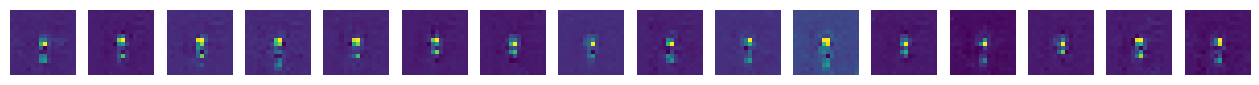

Epoch [29/30] D loss: 0.0038433289155364037 G loss: 0.10186818987131119 FID: 52.48158011577932


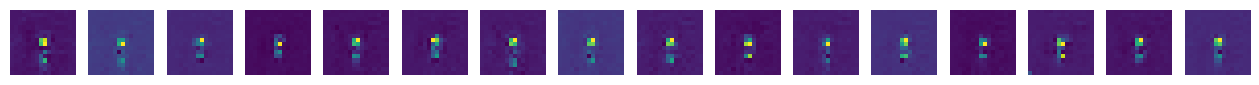

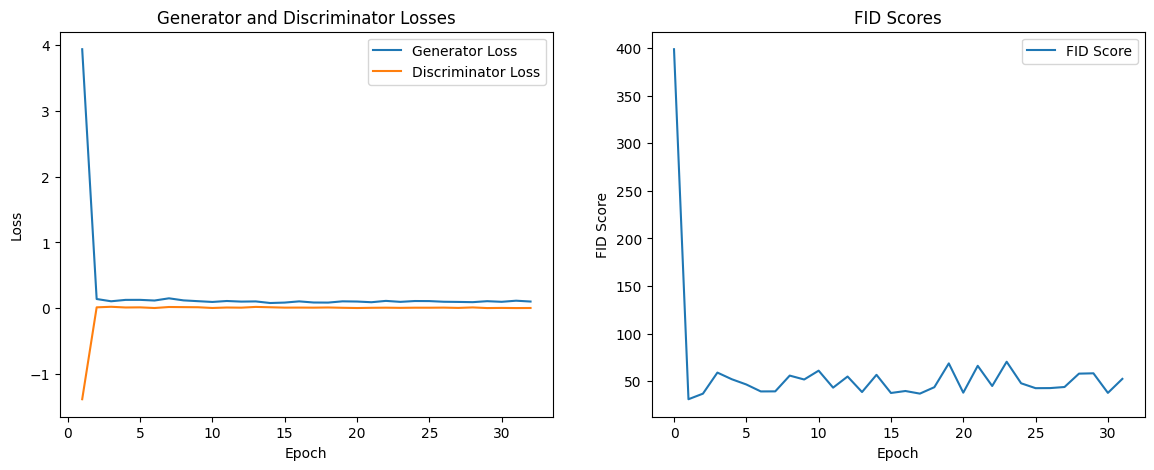

In [ ]:
for epoch in range(n_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        real_samples = real_samples.cuda()
        batch_size = real_samples.size(0)

        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_samples = generator(z).detach()
        real_validity = discriminator(real_samples)
        fake_validity = discriminator(fake_samples)

        gp = gradient_penalty(discriminator, real_samples, fake_samples)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        if i % 5 == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
            gen_samples = generator(z)
            gen_validity = discriminator(gen_samples)

            perceptual_loss_value = perceptual_loss(real_samples, gen_samples, vgg)
            g_loss = -torch.mean(gen_validity) + lambda_perceptual * perceptual_loss_value

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    z = torch.randn(1000, latent_dim, 1, 1).cuda()
    fake_images = generator(z).detach().cpu()
    real_images = next(iter(dataloader))[0][:1000].cpu()

    fid = calculate_fid(real_images, fake_images, batch_size=batch_size)
    fid_scores.append(fid)
    print(f"Epoch [{epoch}/{n_epochs}] D loss: {d_loss.item()} G loss: {g_loss.item()} FID: {fid}")

    output_image = fake_images[:16]  # Save 16 generated samples
    output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    grid = torchvision.utils.make_grid(output_image, nrow=4)
    np_img = grid.numpy().transpose((1, 2, 0))
    plt.imsave(f'classical_Jet_image_PL_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, latent_dim)

plot_metrics(g_losses, d_losses, fid_scores)

In [ ]:
print(g_losses)

[3.93342924118042, 0.14020629227161407, 0.1057906374335289, 0.1269603967666626, 0.12733033299446106, 0.11718712747097015, 0.15081068873405457, 0.11949610710144043, 0.10735379904508591, 0.0955270528793335, 0.1100112646818161, 0.10077296197414398, 0.10373788326978683, 0.07943941652774811, 0.08601066470146179, 0.10428385436534882, 0.0871211513876915, 0.08580352365970612, 0.10494780540466309, 0.10182353109121323, 0.09140593558549881, 0.11170253157615662, 0.0969151183962822, 0.1096348986029625, 0.10859175026416779, 0.09852977097034454, 0.0959799587726593, 0.09238947927951813, 0.10717003047466278, 0.09768899530172348, 0.11448877304792404, 0.10186818987131119]


In [ ]:
print(d_losses)

[-1.3815675973892212, 0.013794193044304848, 0.022201072424650192, 0.011528827250003815, 0.013483656570315361, 0.0034656506031751633, 0.01884545385837555, 0.016884570941329002, 0.015200324356555939, 0.00404078233987093, 0.011140875518321991, 0.008812189102172852, 0.020161917433142662, 0.014915596693754196, 0.009316431358456612, 0.009974295273423195, 0.008916618302464485, 0.011644646525382996, 0.00693508330732584, 0.0033889692276716232, 0.00671355240046978, 0.00853161420673132, 0.005797534249722958, 0.008319198153913021, 0.008024481125175953, 0.009456687606871128, 0.005019264295697212, 0.012477556243538857, 0.0027123205363750458, 0.004894208163022995, 0.002668522298336029, 0.0038433289155364037]


In [ ]:
print(fid_scores)

[398.8341546552085, 31.096111781091285, 36.937361824919506, 59.07270770079462, 52.065108430882695, 46.583540864392134, 39.280521779554185, 39.35491269844282, 55.92528615764331, 51.82118601924279, 61.11137154575812, 43.2616763239873, 54.94483713835481, 38.65162494317748, 56.73430859755508, 37.649287120646235, 39.727142671193306, 36.98009678022985, 43.73012347297779, 68.74605952607297, 37.97443021600215, 66.19820403303244, 44.98999316515746, 70.47978646325072, 47.834641736795035, 42.70155320505098, 42.79210296480596, 43.9311703108076, 57.97148157818546, 58.323054822194415, 37.750787642748875, 52.48158011577932]


## Optimizer Tests

### RMS prop

This implementation is same as Total Variation loss eariler in the notebook

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            spectral_norm(nn.Linear(128*4*4, 1, bias=False))
        )

    def forward(self, x):
        return self.model(x)

def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def total_variation_loss(img):
    batch_size = img.size(0)
    h_x = img.size(2)
    w_x = img.size(3)
    count_h = (img.size(2) - 1) * img.size(3)
    count_w = img.size(2) * (img.size(3) - 1)
    h_tv = torch.pow((img[:,:,1:,:] - img[:,:,:h_x-1,:]), 2).sum()
    w_tv = torch.pow((img[:,:,:,1:] - img[:,:,:,:w_x-1]), 2).sum()
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

def calculate_fid(real_images, fake_images, batch_size=128):
    inception_model = models.inception_v3(pretrained=True, transform_input=False).cuda()
    inception_model.eval()

    def get_features(images):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].cuda()
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.repeat(1, 3, 1, 1)
            with torch.no_grad():
                pred = inception_model(batch)
            features.append(pred.cpu().numpy())
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

latent_dim = 100
lr = 0.0002
n_epochs = 30
lambda_gp = 10
lambda_tv = 1  # Weight for the TV loss term

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []
fid_scores = []

In [ ]:

def plot_metrics(g_losses, d_losses, fid_scores):
    epochs = range(1, len(g_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, g_losses, label='Generator Loss')
    plt.plot(epochs, d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(fid_scores)), fid_scores, label='FID Score')
    plt.xlabel('Epoch')
    plt.ylabel('FID Score')
    plt.legend()
    plt.title('FID Scores')

    plt.show()

In [ ]:
def plot_generated_samples(generator, latent_dim, num_samples=16):
    z = torch.randn(num_samples, latent_dim, 1, 1).cuda()
    gen_samples = generator(z).detach().cpu()
    gen_samples = (gen_samples + 1) / 2.0

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    for i in range(num_samples):
        axes[i].imshow(gen_samples[i, 0])
        axes[i].axis('off')
    plt.show()

Epoch [0/30] D loss: 0.02746192365884781 G loss: 0.0039528291672468185 FID: 93.29845155810668


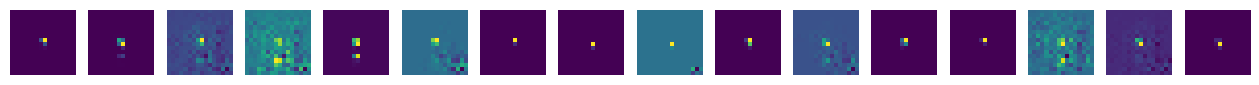

Epoch [1/30] D loss: 0.019246676936745644 G loss: 0.0013159289956092834 FID: 36.30539550663689


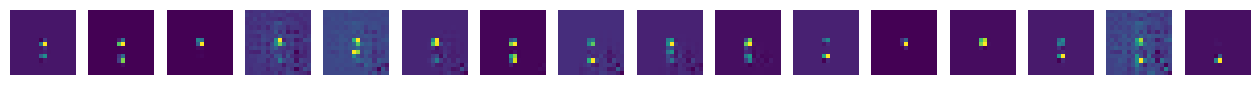

Epoch [2/30] D loss: 0.026658138260245323 G loss: 0.0009284564293920994 FID: 30.006147038862796


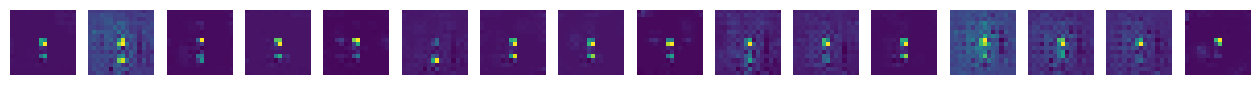

Epoch [3/30] D loss: 0.020669803023338318 G loss: -0.0005337715847417712 FID: 32.40597622829284


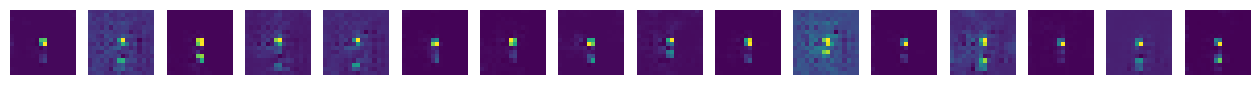

Epoch [4/30] D loss: 0.018099740147590637 G loss: -0.0019225073046982288 FID: 21.469298737190574


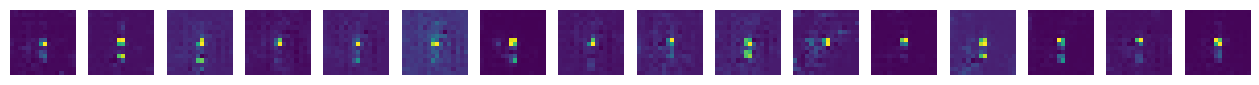

Epoch [5/30] D loss: 0.009189380332827568 G loss: -0.0013928695116192102 FID: 23.780490321127274


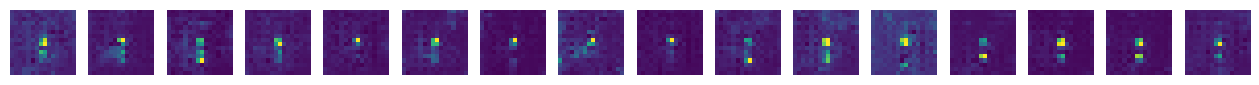

Epoch [6/30] D loss: 0.013716911897063255 G loss: -0.001601258059963584 FID: 16.790268804736325


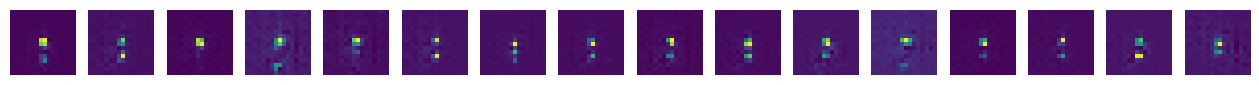

Epoch [7/30] D loss: 0.008081646636128426 G loss: -0.0013119915965944529 FID: 9.914042265470261


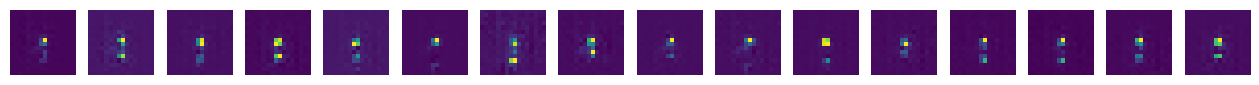

Epoch [8/30] D loss: 0.00932755134999752 G loss: -0.00043691962491720915 FID: 23.148484921492173


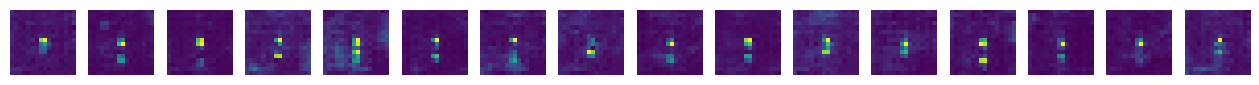

Epoch [9/30] D loss: 0.011399798095226288 G loss: 0.0010216914815828204 FID: 12.20724690671463


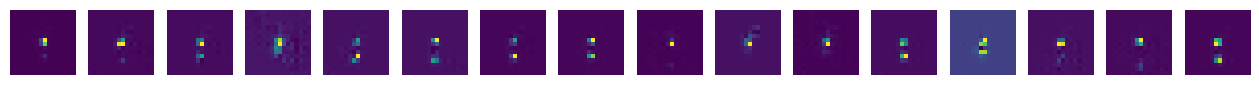

Epoch [10/30] D loss: 0.005722896195948124 G loss: -0.002561692614108324 FID: 27.087333670337106


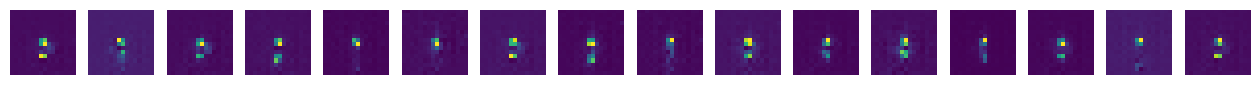

Epoch [11/30] D loss: 0.006410029251128435 G loss: -0.0012247231788933277 FID: 12.455176877820508


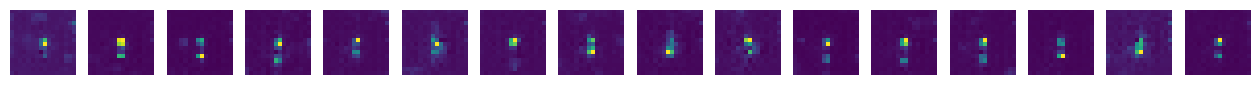

Epoch [12/30] D loss: 0.00944383256137371 G loss: 0.0012751061003655195 FID: 12.586269077165635


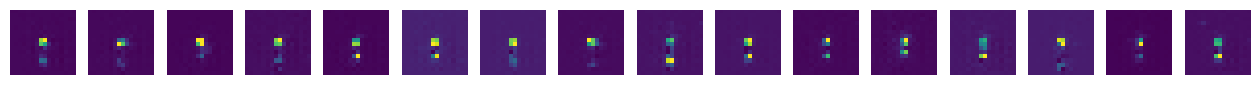

Epoch [13/30] D loss: 0.01095666829496622 G loss: 0.0008090356714092195 FID: 9.915841114817013


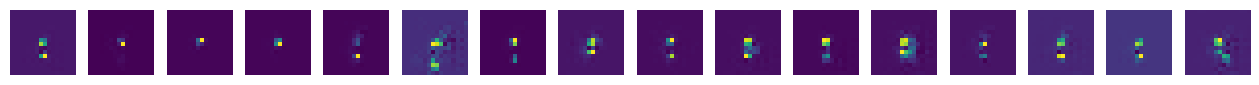

Epoch [14/30] D loss: 0.006795064080506563 G loss: -0.0008724026847630739 FID: 14.087131408919264


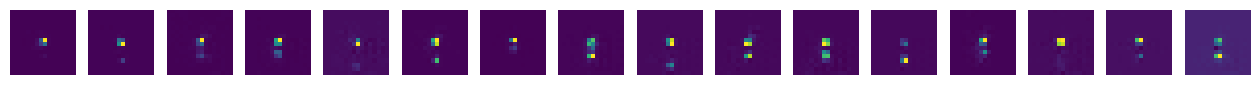

Epoch [15/30] D loss: 0.005142495036125183 G loss: -0.0015080150915309787 FID: 17.63097333729419


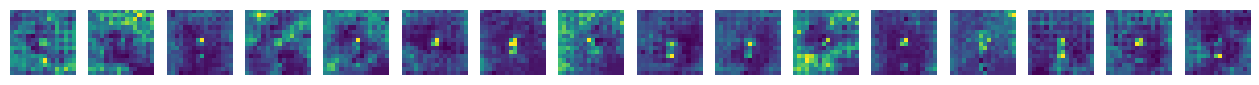

Epoch [16/30] D loss: 0.009226842783391476 G loss: -0.0012593972496688366 FID: 9.730339501955953


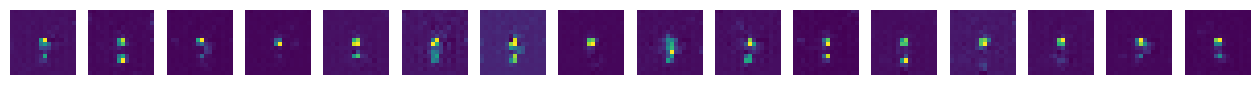

Epoch [17/30] D loss: 0.0039160288870334625 G loss: -0.00014013031614013016 FID: 8.255097472501792


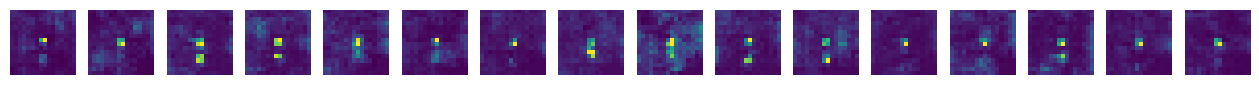

Epoch [18/30] D loss: 0.011105564422905445 G loss: -0.0006619424093514681 FID: 9.616799610127302


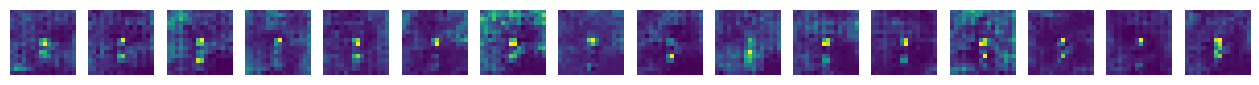

Epoch [19/30] D loss: 0.007202964276075363 G loss: -0.0013317851116880774 FID: 9.221509517401465


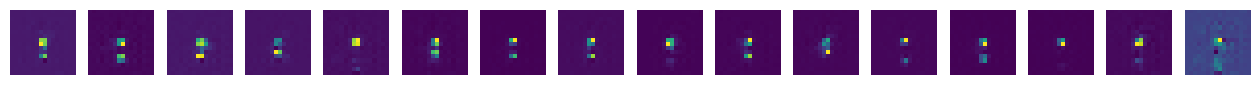

Epoch [20/30] D loss: 0.0076706125400960445 G loss: 7.970890146680176e-05 FID: 8.440994751600346


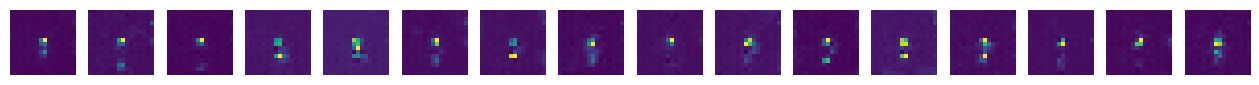

Epoch [21/30] D loss: 0.0075222523882985115 G loss: -0.0016701947897672653 FID: 11.148794005231387


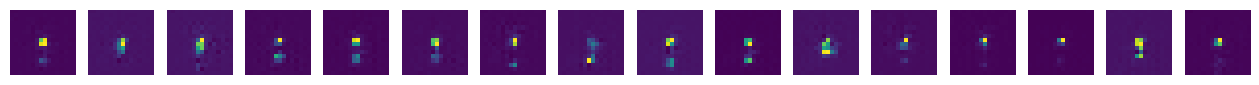

Epoch [22/30] D loss: 0.012016240507364273 G loss: 0.0009253924945369363 FID: 16.37996797718563


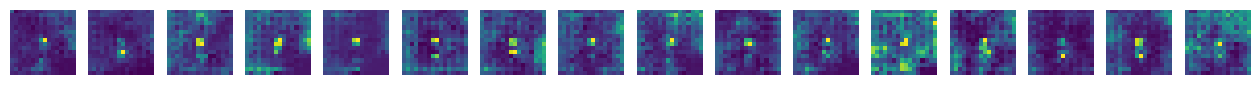

Epoch [23/30] D loss: 0.003989783581346273 G loss: 2.2711465135216713e-05 FID: 8.042175172868474


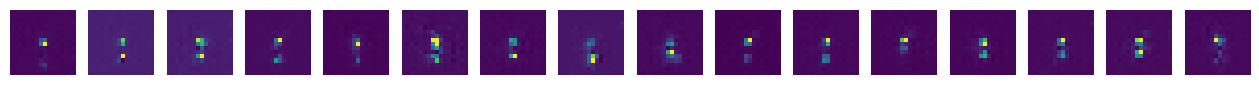

Epoch [24/30] D loss: 0.005785372573882341 G loss: -0.0015750846359878778 FID: 14.08165329320691


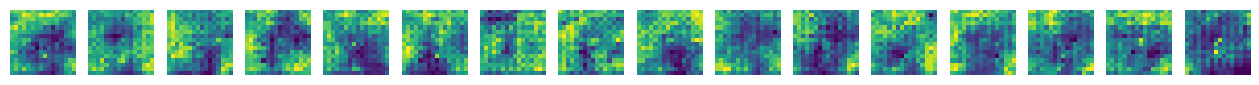

Epoch [25/30] D loss: 0.008715499192476273 G loss: 0.0004631878109648824 FID: 8.671635354852981


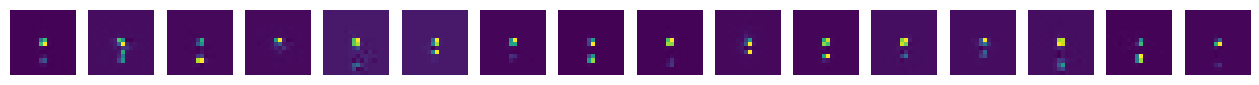

Epoch [26/30] D loss: 0.004658016841858625 G loss: 0.0005534355295822024 FID: 8.364169395082834


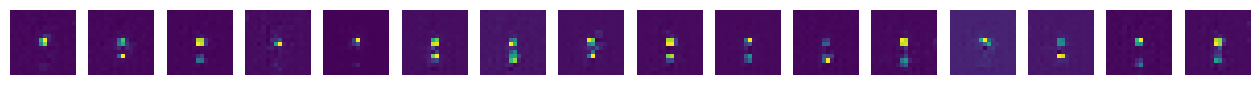

Epoch [27/30] D loss: 0.004257528111338615 G loss: -0.0011766410898417234 FID: 10.755963081274874


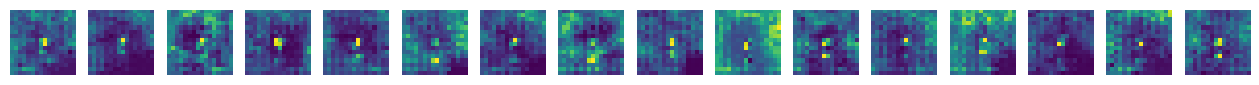

Epoch [28/30] D loss: 0.0062106093391776085 G loss: -0.00038530403980985284 FID: 11.543647471941163


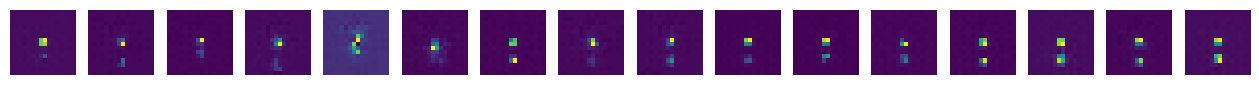

Epoch [29/30] D loss: 0.01293909177184105 G loss: 0.0038950482849031687 FID: 8.114512523308079


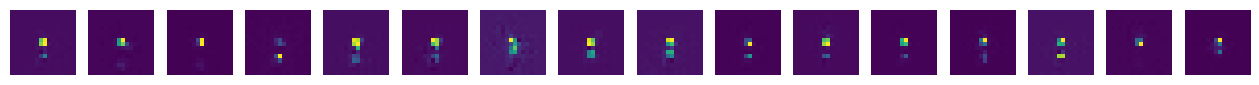

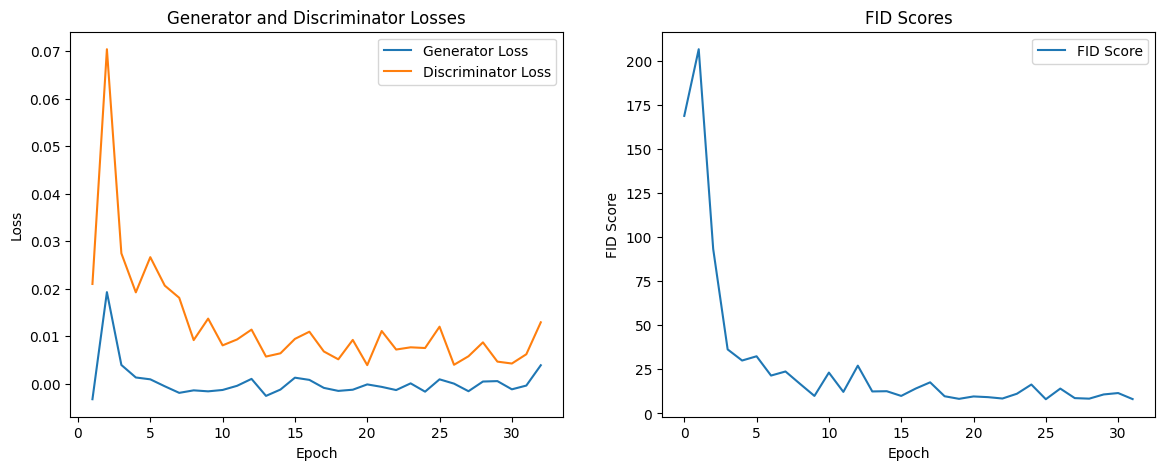

In [ ]:

for epoch in range(n_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        real_samples = real_samples.cuda()
        batch_size = real_samples.size(0)

        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_samples = generator(z).detach()
        real_validity = discriminator(real_samples)
        fake_validity = discriminator(fake_samples)

        gp = gradient_penalty(discriminator, real_samples, fake_samples)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        if i % 5 == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
            gen_samples = generator(z)
            gen_validity = discriminator(gen_samples)

            tv_loss = total_variation_loss(gen_samples)
            g_loss = -torch.mean(gen_validity) + lambda_tv * tv_loss

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    z = torch.randn(1000, latent_dim, 1, 1).cuda()
    fake_images = generator(z).detach().cpu()
    real_images = next(iter(dataloader))[0][:1000].cpu()

    fid = calculate_fid(real_images, fake_images, batch_size=batch_size)
    fid_scores.append(fid)
    print(f"Epoch [{epoch}/{n_epochs}] D loss: {d_loss.item()} G loss: {g_loss.item()} FID: {fid}")

    # Save generated images every epoch
    output_image = fake_images[:16]  # Save 16 generated samples
    output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    grid = torchvision.utils.make_grid(output_image, nrow=4)
    np_img = grid.numpy().transpose((1, 2, 0))
    plt.imsave(f'classical_Jet_image_parameter_shift_epoch_{epoch}.png', np_img)

    plot_generated_samples(generator, latent_dim)

plot_metrics(g_losses, d_losses, fid_scores)

In [ ]:
print(g_losses)

[-0.003261653706431389, 0.019288863986730576, 0.0039528291672468185, 0.0013159289956092834, 0.0009284564293920994, -0.0005337715847417712, -0.0019225073046982288, -0.0013928695116192102, -0.001601258059963584, -0.0013119915965944529, -0.00043691962491720915, 0.0010216914815828204, -0.002561692614108324, -0.0012247231788933277, 0.0012751061003655195, 0.0008090356714092195, -0.0008724026847630739, -0.0015080150915309787, -0.0012593972496688366, -0.00014013031614013016, -0.0006619424093514681, -0.0013317851116880774, 7.970890146680176e-05, -0.0016701947897672653, 0.0009253924945369363, 2.2711465135216713e-05, -0.0015750846359878778, 0.0004631878109648824, 0.0005534355295822024, -0.0011766410898417234, -0.00038530403980985284, 0.0038950482849031687]


In [ ]:
print(d_losses)


[0.02101096138358116, 0.07045307010412216, 0.02746192365884781, 0.019246676936745644, 0.026658138260245323, 0.020669803023338318, 0.018099740147590637, 0.009189380332827568, 0.013716911897063255, 0.008081646636128426, 0.00932755134999752, 0.011399798095226288, 0.005722896195948124, 0.006410029251128435, 0.00944383256137371, 0.01095666829496622, 0.006795064080506563, 0.005142495036125183, 0.009226842783391476, 0.0039160288870334625, 0.011105564422905445, 0.007202964276075363, 0.0076706125400960445, 0.0075222523882985115, 0.012016240507364273, 0.003989783581346273, 0.005785372573882341, 0.008715499192476273, 0.004658016841858625, 0.004257528111338615, 0.0062106093391776085, 0.01293909177184105]


In [ ]:
print(fid_scores)

[168.7999051876385, 206.63031919808947, 93.29845155810668, 36.30539550663689, 30.006147038862796, 32.40597622829284, 21.469298737190574, 23.780490321127274, 16.790268804736325, 9.914042265470261, 23.148484921492173, 12.20724690671463, 27.087333670337106, 12.455176877820508, 12.586269077165635, 9.915841114817013, 14.087131408919264, 17.63097333729419, 9.730339501955953, 8.255097472501792, 9.616799610127302, 9.221509517401465, 8.440994751600346, 11.148794005231387, 16.37996797718563, 8.042175172868474, 14.08165329320691, 8.671635354852981, 8.364169395082834, 10.755963081274874, 11.543647471941163, 8.114512523308079]


### Adam Optimzer


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            spectral_norm(nn.Linear(128*4*4, 1, bias=False))
        )

    def forward(self, x):
        return self.model(x)

def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def total_variation_loss(img):
    batch_size = img.size(0)
    h_x = img.size(2)
    w_x = img.size(3)
    count_h = (img.size(2) - 1) * img.size(3)
    count_w = img.size(2) * (img.size(3) - 1)
    h_tv = torch.pow((img[:,:,1:,:] - img[:,:,:h_x-1,:]), 2).sum()
    w_tv = torch.pow((img[:,:,:,1:] - img[:,:,:,:w_x-1]), 2).sum()
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

def calculate_fid(real_images, fake_images, batch_size=128):
    inception_model = models.inception_v3(pretrained=True, transform_input=False).cuda()
    inception_model.eval()

    def get_features(images):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].cuda()
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.repeat(1, 3, 1, 1)
            with torch.no_grad():
                pred = inception_model(batch)
            features.append(pred.cpu().numpy())
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

latent_dim = 100
lr = 0.0002
n_epochs = 30
lambda_gp = 10
lambda_tv = 1  # Weight for the TV loss term

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

g_losses = []
d_losses = []
fid_scores = []

C:\Users\adith\anaconda3\envs\gsoc\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\adith\anaconda3\envs\gsoc\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
C:\Users\adith\anaconda3\envs\gsoc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' in

Epoch [0/30] D loss: 0.0037746652960777283 G loss: 0.009380880743265152 FID: 150.05767757695207


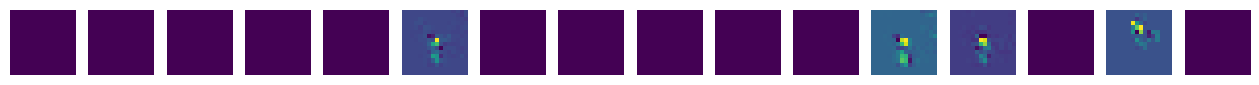

Epoch [1/30] D loss: 0.014995462261140347 G loss: -0.011029670014977455 FID: 122.2937847862413


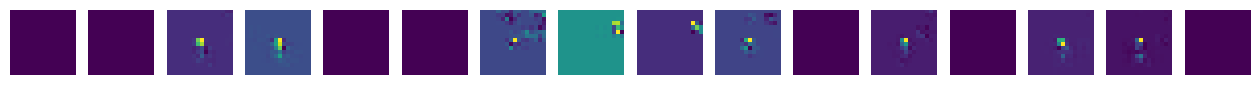

Epoch [2/30] D loss: 0.006480103358626366 G loss: -0.005296018905937672 FID: 115.29251789422638


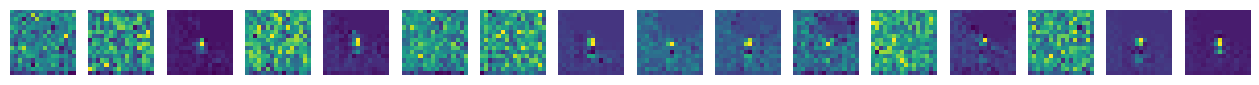

Epoch [3/30] D loss: 0.018171275034546852 G loss: -0.0002471081679686904 FID: 131.2450674214296


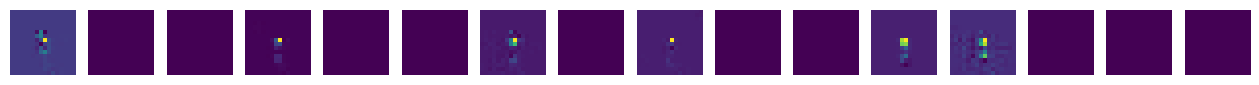

Epoch [4/30] D loss: 0.021144840866327286 G loss: 0.0025514799635857344 FID: 103.2876092288144


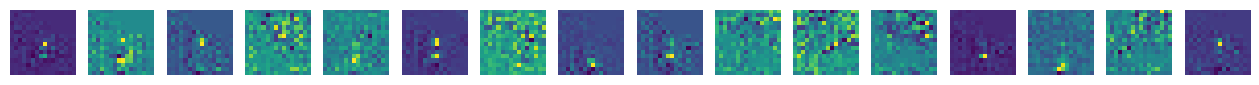

Epoch [5/30] D loss: 0.023461882025003433 G loss: -0.018191982060670853 FID: 113.00038751110554


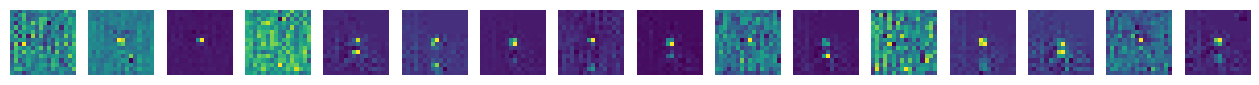

Epoch [6/30] D loss: 0.04138507321476936 G loss: -0.026391079649329185 FID: 136.8240946100962


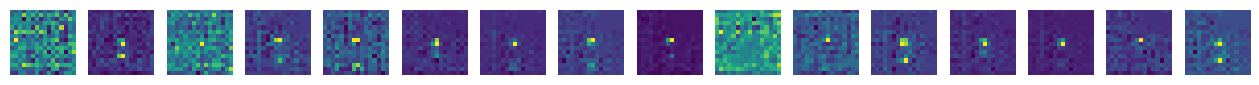

Epoch [7/30] D loss: 0.033862315118312836 G loss: 0.0038687135092914104 FID: 98.67234727857002


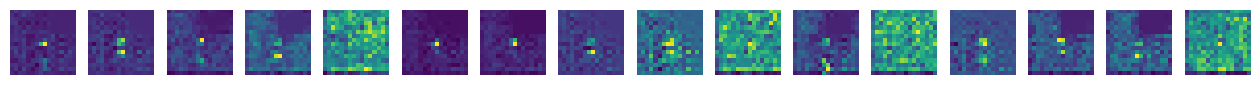

Epoch [8/30] D loss: 0.028984278440475464 G loss: -0.0017822913359850645 FID: 71.30117359857671


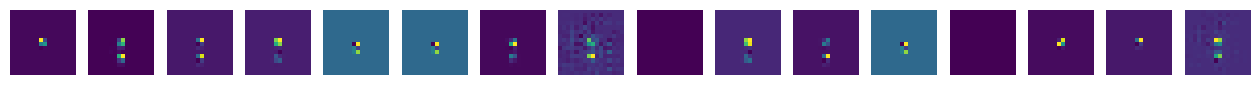

Epoch [9/30] D loss: 0.014306247234344482 G loss: -0.0009197742328979075 FID: 68.25144795971634


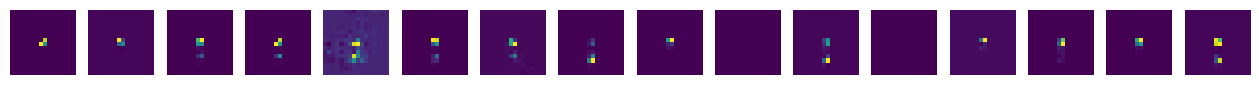

Epoch [10/30] D loss: 0.015323651023209095 G loss: -0.0020976404193788767 FID: 53.20623615670104


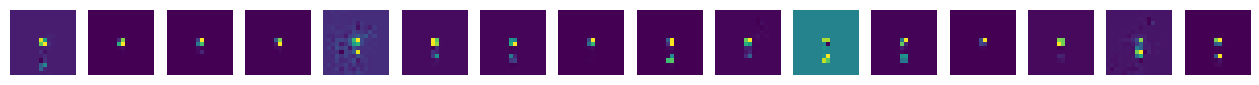

Epoch [11/30] D loss: 0.015050696209073067 G loss: 0.003261628095060587 FID: 29.341515539784478


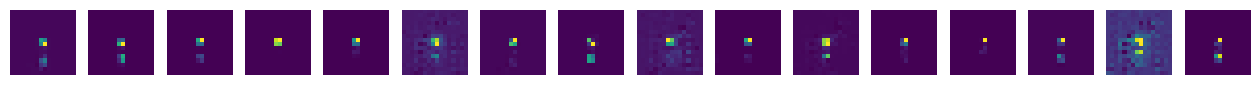

Epoch [12/30] D loss: 0.02290854975581169 G loss: -0.003130233148112893 FID: 60.85219081401102


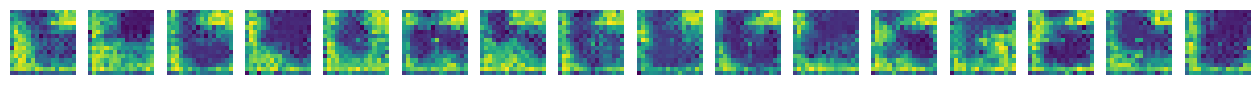

Epoch [13/30] D loss: 0.02186933532357216 G loss: -4.934237222187221e-05 FID: 28.798705903346


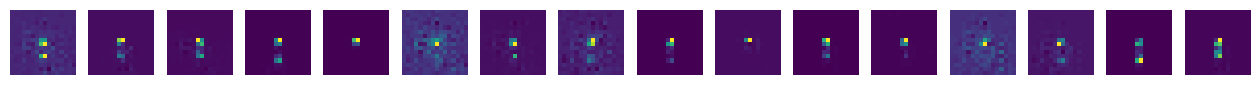

Epoch [14/30] D loss: 0.017948532477021217 G loss: 0.002304139779880643 FID: 19.979721780296856


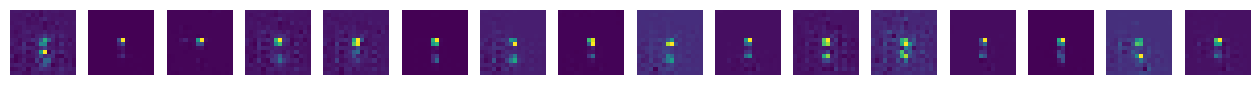

Epoch [15/30] D loss: 0.011404241435229778 G loss: 0.0054090190678834915 FID: 29.00544994644619


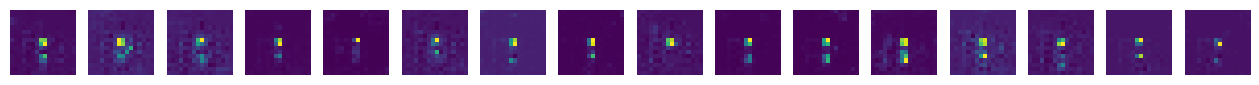

Epoch [16/30] D loss: 0.01705462485551834 G loss: -0.0014313339488580823 FID: 19.660958363415595


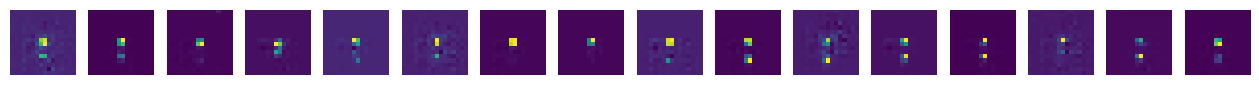

Epoch [17/30] D loss: 0.007059692870825529 G loss: -0.002568355528637767 FID: 17.68989713802941


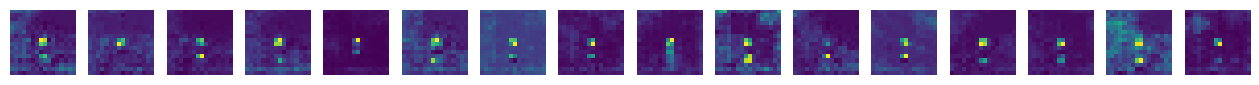

Epoch [18/30] D loss: 0.009977512061595917 G loss: 0.005225562956184149 FID: 19.263442387959135


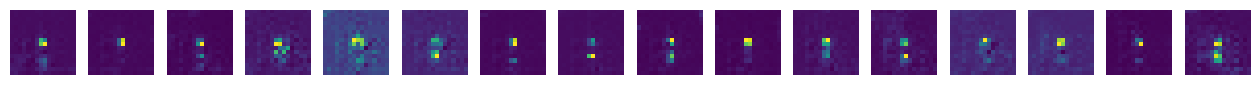

Epoch [19/30] D loss: 0.01069087628275156 G loss: -0.0004859302716795355 FID: 15.752782186955642


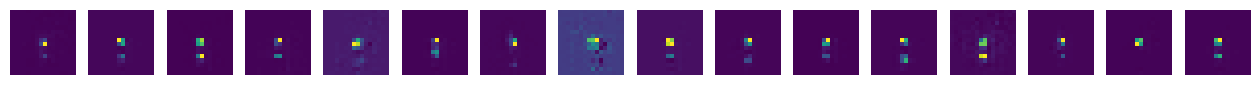

Epoch [20/30] D loss: 0.012969553470611572 G loss: 0.00010154425399377942 FID: 20.131310331120837


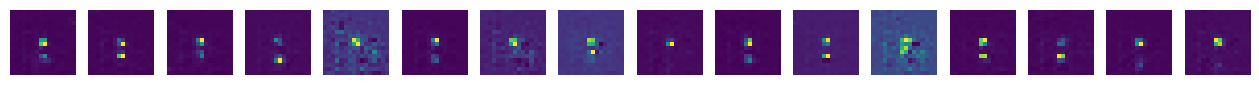

Epoch [21/30] D loss: 0.010836316272616386 G loss: 0.0027841220144182444 FID: 22.188474879723387


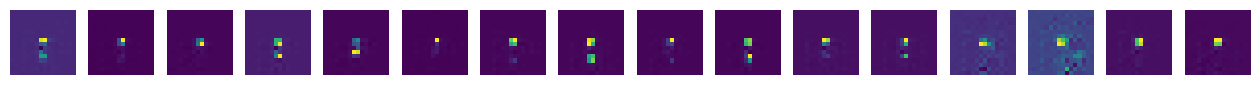

Epoch [22/30] D loss: 0.0069221751764416695 G loss: -0.0026495419442653656 FID: 20.858248561397062


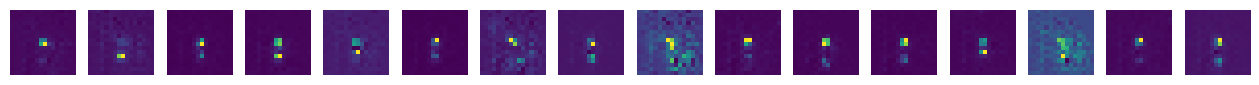

Epoch [23/30] D loss: 0.009031488560140133 G loss: -0.000843919231556356 FID: 23.675357278061195


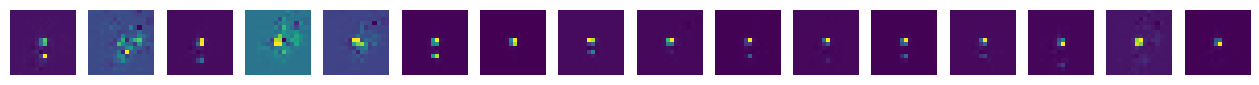

Epoch [24/30] D loss: 0.014399955049157143 G loss: 0.00011582218576222658 FID: 17.66745587355812


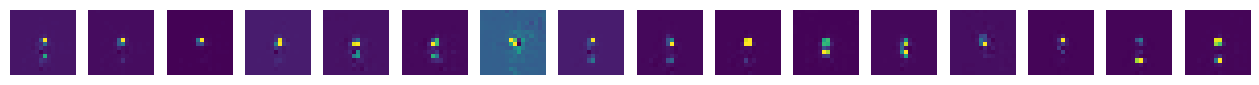

Epoch [25/30] D loss: 0.005721250548958778 G loss: -0.001520012505352497 FID: 15.106002718573045


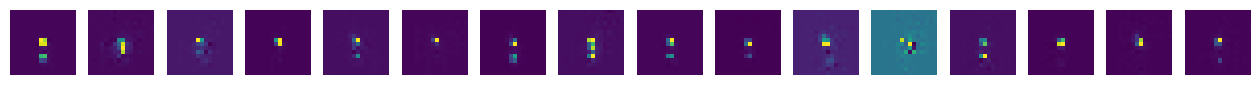

Epoch [26/30] D loss: 0.006752653047442436 G loss: -0.0007826180662959814 FID: 13.247232866607277


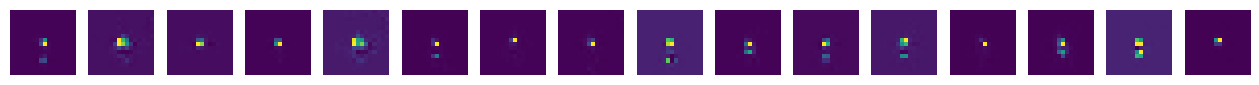

Epoch [27/30] D loss: 0.009292472153902054 G loss: -0.0019391578389331698 FID: 10.170017515134258


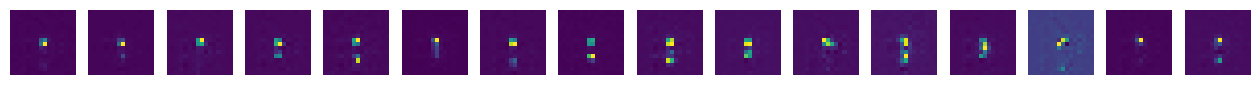

Epoch [28/30] D loss: 0.010048788040876389 G loss: 0.0049369437620043755 FID: 9.190552705890834


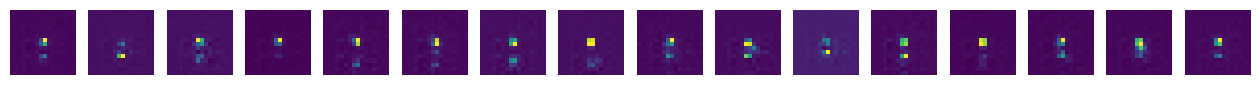

Epoch [29/30] D loss: 0.0036754123866558075 G loss: -0.0011622007004916668 FID: 9.058682051250265


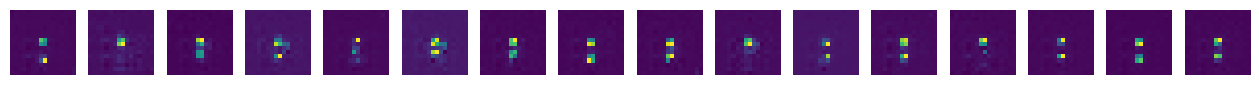

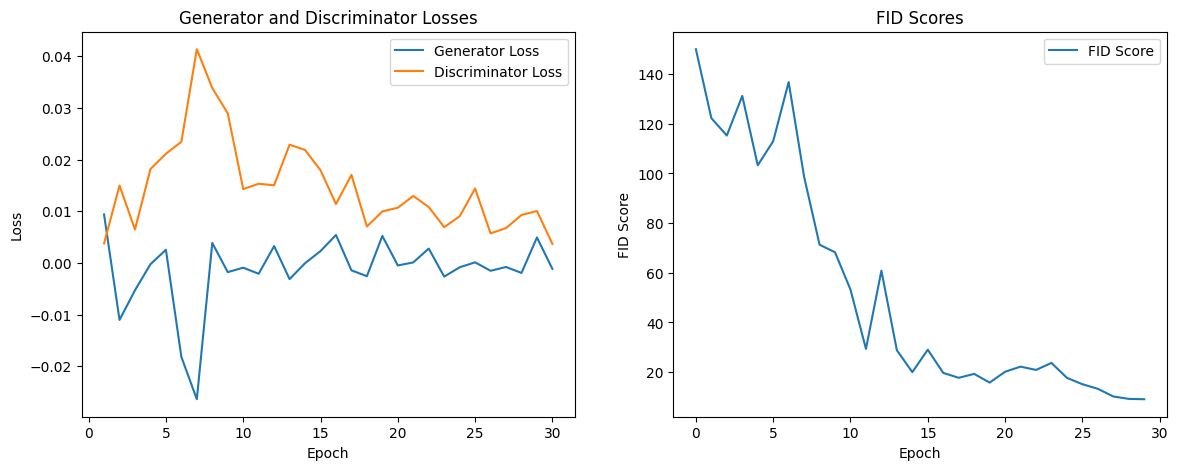

In [ ]:
for epoch in range(n_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        real_samples = real_samples.cuda()
        batch_size = real_samples.size(0)

        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        fake_samples = generator(z).detach()
        real_validity = discriminator(real_samples)
        fake_validity = discriminator(fake_samples)

        gp = gradient_penalty(discriminator, real_samples, fake_samples)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        if i % 5 == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim, 1, 1).cuda()
            gen_samples = generator(z)
            gen_validity = discriminator(gen_samples)

            tv_loss = total_variation_loss(gen_samples)
            g_loss = -torch.mean(gen_validity) + lambda_tv * tv_loss

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    z = torch.randn(1000, latent_dim, 1, 1).cuda()
    fake_images = generator(z).detach().cpu()
    real_images = next(iter(dataloader))[0][:1000].cpu()

    fid = calculate_fid(real_images, fake_images, batch_size=batch_size)
    fid_scores.append(fid)
    print(f"Epoch [{epoch}/{n_epochs}] D loss: {d_loss.item()} G loss: {g_loss.item()} FID: {fid}")

    # Save generated images every epoch
    output_image = fake_images[:16]  # Save 16 generated samples
    output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    grid = torchvision.utils.make_grid(output_image, nrow=4)
    np_img = grid.numpy().transpose((1, 2, 0))
    plt.imsave(f'classical_Jet_image__adam_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, latent_dim)

plot_metrics(g_losses, d_losses, fid_scores)